In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error as mae
import os
!pip3 install pathlib2
from pathlib2 import Path
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks

#ALL FUNCTIONS USED IN CODE 

In [ ]:
def load_dataset(file_path):
    """
    Load a single dataset.
    """
    df_data = pd.read_csv(file_path, index_col="Date")
    return df_data

def load_aggregated_datasets(file_paths):
    """
    Load and pre-process datasets from various markets.
    """
    
    market_orders = [] # store the order which markets are processed
    n_markets = 0 # number of markets used
    aggregated_datasets = {}
    
    # Iterate over different indices data to load and process them
    for file_path in file_paths:
        df_data = load_dataset(file_path)
        
        ## Store information on the order of datasets that are processed
        data_name = df_data["Name"][0]
        print(df_data["Name"][0])
        market_orders.append(data_name)
        del df_data["Name"]
        n_markets += 1
        
        ## Preprocess data
        label = (df_data["Close"][1:] / df_data["Close"][:-1].values).astype(int)
        df_data = df_data[:-1]
        label.index = df_data.index
        
        # do not use the first 200 data as we use moving average as one of the feature
        df_data = df_data[200:]
        df_data[CLASS_NAME] = label
        
        ## Store in dictionary
        aggregated_datasets[data_name] = df_data
    
    return market_orders, n_markets, aggregated_datasets




# The above code generate vanilla datasets, the following generate
# sequential datasets.
def generate_sequential_data(df_data, sequence_length):
    """
    Given a dataframe and sequence length, generate sequential data.
    """
    
    label = list(df_data[CLASS_NAME])
    df_data = df_data.drop(columns=[CLASS_NAME])
    sequential_data = [] # used to store sequential data
    sequential_target = []
    
    ## Sequencing data
    for idx in range(df_data.shape[0]-sequence_length+1):
        sequential_data.append(df_data[idx:idx+sequence_length])
        sequential_target.append(label[idx+sequence_length-1])
    
    ## Notes:
    # - If using conv net, add 1 dimension by reshape later.
    # - convert the sequential_data list of df to np array later
    
    return sequential_data, sequential_target


# The above code generate vanilla datasets, the following generate
# sequential datasets.
def generate_sequential_data_3d(data, target, sequence_length):
    """
    Given a dataframe and sequence length, generate sequential data (for 3d cnn pred).
    """
    sequential_data = []
    sequential_target = []
    
    ## Sequencing data
    for idx in range(data.shape[1]-sequence_length+1):
        sequential_data.append(data[:, idx:idx+sequence_length])
        sequential_target.append(target[idx+sequence_length-1])
    
    sequential_data = np.array(sequential_data)
    sequential_target = np.array(sequential_target)
    
    return sequential_data, sequential_target

def generate_all_sequential_data(sequence_length, df_datas=None):
    """
    Generate aggregated dataset from all markets.
    """
    
    sequential_data = []
    sequential_target = []
    
    # Load datasets
    ## If the datasets are not specified, used all datas
    if df_datas is None:
        market_orders, n_markets, aggregated_datasets = load_aggregated_datasets([DATASET_DJI, 
                                                                              DATASET_NASDAQ, 
                                                                              DATASET_NYSE,
                                                                              DATASET_RUSSELL, 
                                                                              DATASET_SP])
        
        # Iterate over all datasets and generate sequential version of it
        for market in market_orders:
            seq_data, seq_target = generate_sequential_data(aggregated_datasets[market], sequence_length)
            sequential_data.extend(seq_data)
            sequential_target.extend(seq_target)
            
    else:
        df_datas = df_datas
        
        for df_data in df_datas:
            seq_data, seq_target = generate_sequential_data(df_data, sequence_length)
            sequential_data.extend(seq_data)
            sequential_target.extend(seq_target)

    
    return sequential_data, sequential_target

def sequential_reshape(X_seq, reshape_size):
    """
    Reshape sequential data into required format.
    """
    
    X_seq_new = [X_seq[i].to_numpy() for i in range(len(X_seq))]
    X_seq_new = np.array(X_seq_new)
    X_seq_new = X_seq_new.reshape(reshape_size)
    
    return X_seq_new

def analyse_cv(model, X_train, y_train, cv, scoring):
    """
    Do cross validation and compute relevant statistics.
    """
    
    scores = cross_val_score(model, X_train, y_train,
                             scoring=scoring, cv=cv)
    
    print("Scores:", scores)
    print("Mean Scores:", scores.mean())
    print("Standard deviation:", scores.std())

def stacking_classifier():
    """
    Create stack classifier.
    """
    
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))

    # define meta learner model
    level1 = LogisticRegression()

    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return model

def cnnpred_2d(sequence_length, n_feature, n_filters, dropout_rate=0.1):
    """
    Build model using architecture that is specified on the paper
    (Hoseinzade and Haratizadeh).
    """
    
    model = keras.Sequential([
        # Layer 1
        keras.Input(shape=(sequence_length, n_feature, 1)),
        layers.Conv2D(n_filters[0], (1, n_feature), activation="relu"),
        
        # Layer 2
        layers.Conv2D(n_filters[1], (3, 1), activation="relu"),
        layers.MaxPool2D(pool_size=(2, 1)),
        
        # Layer 3
        layers.Conv2D(n_filters[2], (3, 1), activation="relu"),
        layers.MaxPool2D(pool_size=(2, 1)),
        
        # FFNN
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation="sigmoid")
    ])
    
    return model


def cnnpred_3d(n_markets, sequence_length, n_feature, n_filters):
    """
    Build model using architecture that is specified on the paper
    (Hoseinzade and Haratizadeh).
    """
    
    model = keras.Sequential([
        # layer 1
        layers.Conv2D(n_filters[0], (1, 1), activation='relu', 
                      input_shape=(n_markets,sequence_length,n_feature), data_format='channels_last'),
        
        # layer 2
        layers.Conv2D(n_filters[1], (n_markets, 3), activation="relu"),
        layers.MaxPool2D(pool_size=(1, 2)),
        
        # layer 3
        layers.Conv2D(n_filters[2], (1, 3), activation="relu"),
        layers.MaxPool2D(pool_size=(1, 2)),
        
        # FFNN
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid")
    ])
    
    return model

def lstm(win_length, num_features):
    """
    Build LSTM model for predicting stock market direction.
    """
    
    model = tf.keras.Sequential()
    model.add(layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
    model.add(layers.LeakyReLU(alpha=0.5))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    return model

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_pos = precision(y_true, y_pred)
    recall_pos = recall(y_true, y_pred)
    precision_neg = precision((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    recall_neg = recall((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    f_posit = 2 * ((precision_pos * recall_pos) / (precision_pos + recall_pos + K.epsilon()))
    f_neg = 2 * ((precision_neg * recall_neg) / (precision_neg + recall_neg + K.epsilon()))

    return (f_posit + f_neg) / 2

def plot_confusion_matrix(y_test, y_predict, labels, cmap="Blues"):
    # Plot confusion matrix and normalised confusion matrix
    fig1 = plt.figure(figsize=(4,4))
    fig2 = plt.figure(figsize=(4,4))
    ax1 = fig1.add_subplot(111)
    ax2 = fig2.add_subplot(111)
    cm = confusion_matrix(y_test, y_predict)
    disp = ConfusionMatrixDisplay(cm)
    disp = disp.plot(ax=ax1, cmap=cmap)
    cm_n = confusion_matrix(y_test, y_predict, normalize="true")
    disp_n = ConfusionMatrixDisplay(cm_n)
    disp_n = disp_n.plot(ax=ax2, cmap=cmap)
            
    ax1.set_xticklabels(labels)
    ax1.set_yticklabels(labels, rotation=90)
    ax2.set_xticklabels(labels)
    ax2.set_yticklabels(labels, rotation=90)
    ax1.set_xlabel("$Predicted$")
    ax2.set_xlabel("$Predicted$")
    ax1.set_ylabel("$True$")
    ax2.set_ylabel("$True$")
    plt.show()


def plot_pr_vs_threshold(precisions, recalls, thresholds):
    """
    Plot precision and recall against threshold.
    """
    
    fig = plt.figure(figsize=(6,4))
    ax = plt.subplot2grid((1,1), (0,0))
    ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
    ax.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0, 1])
    
    return ax

def plot_roc_curve(fpr, tpr, label=None):
    """
    Plot roc curve.
    """
    
    fig = plt.figure(figsize=(6,4))
    ax = plt.subplot2grid((1,1), (0,0))
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.plot([0, 1], [0, 1], "k--")
    ax.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    
    return ax

#EXPLORING DATA 

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive')
link1 ='/content/drive/MyDrive/Colab Notebooks/DATA/Processed_DJI.csv'
link2 ='/content/drive/MyDrive/Colab Notebooks/DATA/Processed_NASDAQ.csv'
link3 ='/content/drive/MyDrive/Colab Notebooks/DATA/Processed_NYSE.csv'
link4 ='/content/drive/MyDrive/Colab Notebooks/DATA/Processed_RUSSELL.csv'
link5 ='/content/drive/MyDrive/Colab Notebooks/DATA/Processed_S&P.csv'
CLASS_NAME = "MOVEMENT"
DATASET_DJI = open(link1,)
DATASET_NASDAQ = open(link2,)
DATASET_NYSE = open(link3,)
DATASET_RUSSELL = open(link4,)
DATASET_SP = open(link5,)
market_orders, n_markets, aggregated_datasets = load_aggregated_datasets([DATASET_DJI, 
                                                                          DATASET_NASDAQ, 
                                                                          DATASET_NYSE,
                                                                          DATASET_RUSSELL, 
                                                                          DATASET_SP])

# Load datasets
## DJI
dji_df = aggregated_datasets["DJI"]
## NASDAQ
nasdaq_df = aggregated_datasets["NASDAQ"]
## NYSE
nyse_df = aggregated_datasets["NYA"]
## Russell
russell_df = aggregated_datasets["RUT"]
## SP
sp_df = aggregated_datasets["S&P"]

KeyboardInterrupt: ignored

In [ ]:
#market_orders, n_markets, aggregated_datasets

CLEANING 


In [ ]:
## DJI
for col, n_null in zip(dji_df.columns, dji_df.isnull().sum()):
    print(f"{col}: {n_null}")
dji_df.shape[0] - dji_df.dropna().shape[0]

## NASDAQ
for col, n_null in zip(nasdaq_df.columns, nasdaq_df.isnull().sum()):
    print(f"{col}: {n_null}")

nasdaq_df.shape[0] - nasdaq_df.dropna().shape[0]

## RUSSELL
for col, n_null in zip(russell_df.columns, russell_df.isnull().sum()):
    print(f"{col}: {n_null}")
russell_df.shape[0] - russell_df.dropna().shape[0]


## NYSE
for col, n_null in zip(nyse_df.columns, nyse_df.isnull().sum()):
    print(f"{col}: {n_null}")

## S&P 500
for col, n_null in zip(sp_df.columns, sp_df.isnull().sum()):
    print(f"{col}: {n_null}")
sp_df.shape[0] - sp_df.dropna().shape[0]

# Fill missing values, do some scaling (run prev cell first)
list_df = []

for df in [dji_df, nasdaq_df, nyse_df, russell_df, sp_df]:
    columns = df.columns
    df.fillna(0, inplace=True) # fill na with 0
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    X["MOVEMENT"] = np.array(y)
    X.columns = columns
    list_df.append(X)
    
### Clean dataframe (full features)
dji_df_full = list_df[0]
nasdaq_df_full = list_df[1]
nyse_df_full = list_df[2]
russell_df_full = list_df[3]
sp_df_full = list_df[4]

Close: 0
Volume: 0
mom: 0
mom1: 0
mom2: 0
mom3: 0
ROC_5: 0
ROC_10: 0
ROC_15: 0
ROC_20: 0
EMA_10: 0
EMA_20: 0
EMA_50: 0
EMA_200: 0
DTB4WK: 0
DTB3: 0
DTB6: 0
DGS5: 0
DGS10: 0
Oil: 0
Gold: 0
DAAA: 0
DBAA: 0
GBP: 422
JPY: 423
CAD: 427
CNY: 423
AAPL: 0
AMZN: 0
GE: 0
JNJ: 0
JPM: 0
MSFT: 0
WFC: 0
XOM: 0
FCHI: 37
FTSE: 63
GDAXI: 63
GSPC: 0
HSI: 153
IXIC: 0
SSEC: 212
RUT: 0
NYSE: 0
TE1: 0
TE2: 0
TE3: 0
TE5: 0
TE6: 0
DE1: 0
DE2: 0
DE4: 0
DE5: 0
DE6: 0
CTB3M: 0
CTB6M: 0
CTB1Y: 0
AUD: 0
Brent: 0
CAC-F: 4
copper-F: 0
WIT-oil: 0
DAX-F: 4
DJI-F: 0
EUR: 0
FTSE-F: 6
gold-F: 0
HSI-F: 67
KOSPI-F: 71
NASDAQ-F: 0
GAS-F: 0
Nikkei-F: 0
NZD: 0
silver-F: 0
RUSSELL-F: 0
S&P-F: 0
CHF: 0
Dollar index-F: 0
Dollar index: 0
wheat-F: 0
XAG: 0
XAU: 0
MOVEMENT: 0
Close: 0
Volume: 0
mom: 0
mom1: 0
mom2: 0
mom3: 0
ROC_5: 0
ROC_10: 0
ROC_15: 0
ROC_20: 0
EMA_10: 0
EMA_20: 0
EMA_50: 0
EMA_200: 0
DTB4WK: 0
DTB3: 0
DTB6: 0
DGS5: 0
DGS10: 0
Oil: 0
Gold: 0
DAAA: 0
DBAA: 0
GBP: 422
JPY: 423
CAD: 427
CNY: 423
AAPL: 0
AMZN: 0
GE: 

##In this section, we examine the attributes, including correlation with class variable, class distribution, key variables distributions.

Close      1.000000
EMA_10     0.998567
EMA_20     0.997054
EMA_50     0.993439
EMA_200    0.981826
             ...   
DBAA      -0.499950
DE2       -0.530913
DE6       -0.654388
DE5       -0.668665
DE4       -0.691931
Name: Close, Length: 82, dtype: float64
EMA_10     1.000000
EMA_20     0.999497
Close      0.998567
EMA_50     0.996608
EMA_200    0.985025
             ...   
DBAA      -0.500326
DE2       -0.529044
DE6       -0.654175
DE5       -0.668186
DE4       -0.691793
Name: EMA_10, Length: 82, dtype: float64


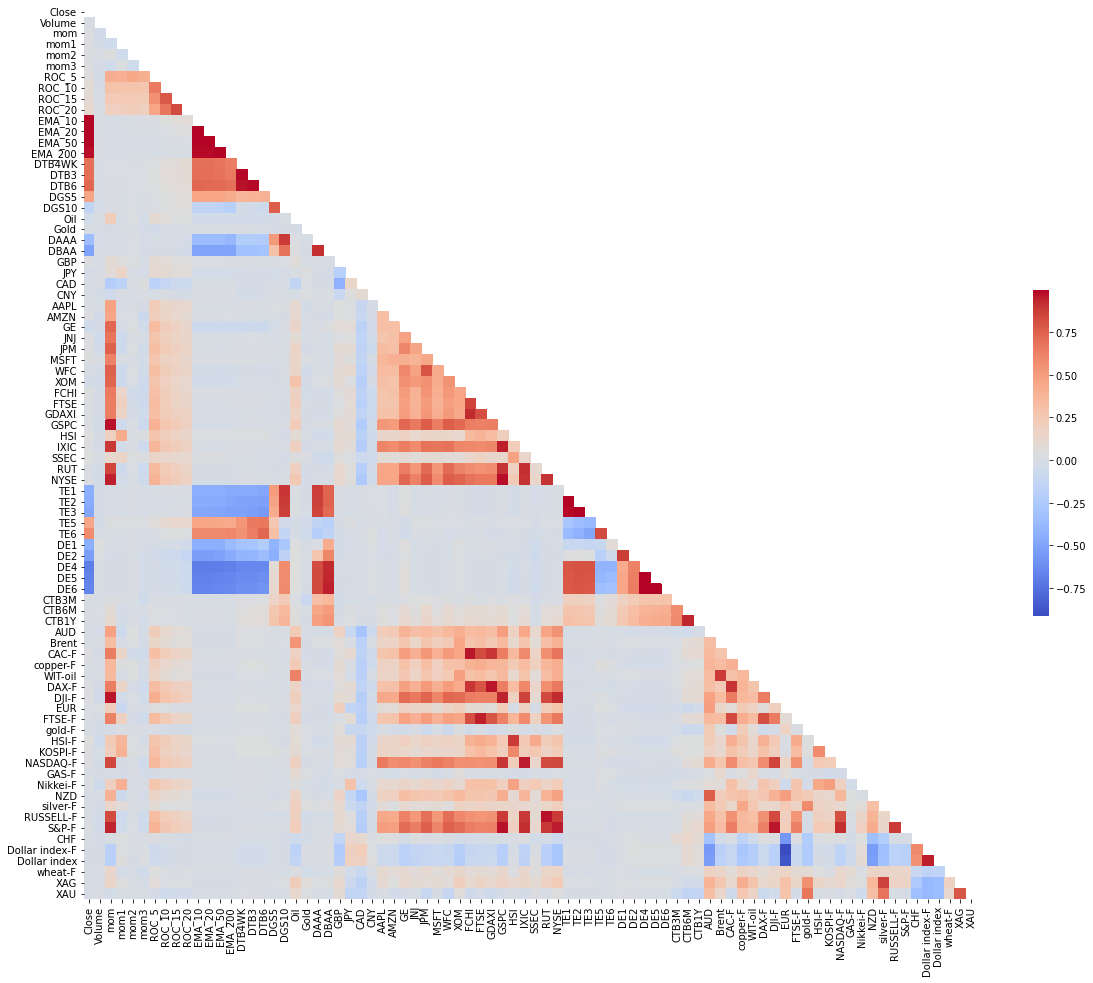

In [ ]:
## DJI
corr_dji = dji_df_full.drop(columns=["MOVEMENT"]).corr()
print(corr_dji["Close"].sort_values(ascending=False))
print(corr_dji["EMA_10"].sort_values(ascending=False))
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)
mask=np.zeros_like(corr_dji)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_dji,
            xticklabels=corr_dji.columns,
            yticklabels=corr_dji.columns,
           ax=ax, mask=mask, square=True,
            cbar_kws={"shrink": 0.2},
           cmap="coolwarm")
plt.show()

Close      1.000000
EMA_10     0.999020
EMA_20     0.998047
EMA_50     0.995808
EMA_200    0.987986
             ...   
DE2       -0.483351
TE3       -0.489184
DE6       -0.624978
DE5       -0.640634
DE4       -0.668632
Name: Close, Length: 82, dtype: float64


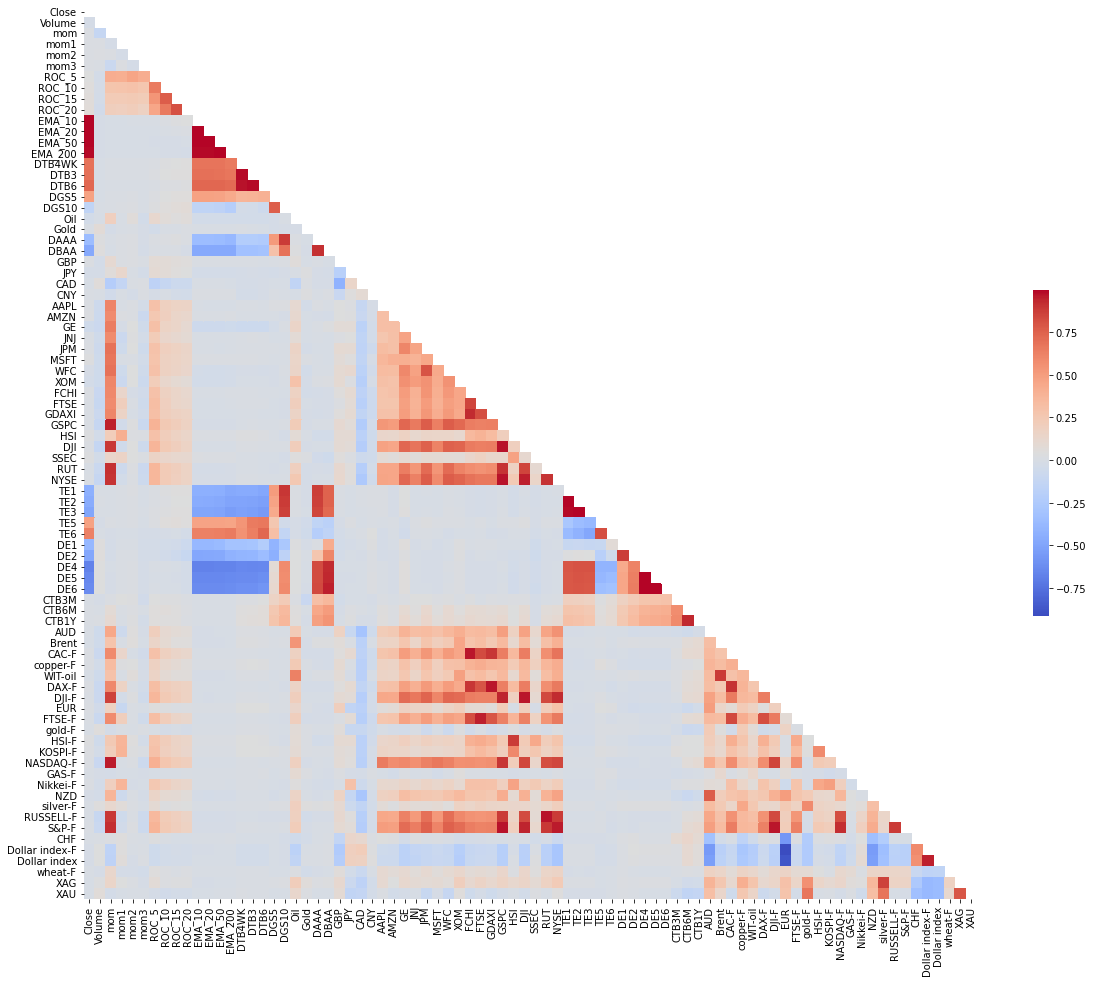

In [ ]:
## NASDAQ
corr_dji = nasdaq_df_full.drop(columns=["MOVEMENT"]).corr()
print(corr_dji["Close"].sort_values(ascending=False))
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)
mask=np.zeros_like(corr_dji)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_dji,
            xticklabels=corr_dji.columns,
            yticklabels=corr_dji.columns,
           ax=ax, mask=mask, square=True,
            cbar_kws={"shrink": 0.2},
           cmap="coolwarm")
plt.show()

Close      1.000000
EMA_10     0.997126
EMA_20     0.994285
EMA_50     0.986977
EMA_200    0.958281
             ...   
DE1       -0.549688
DE6       -0.558625
DE5       -0.567956
DE4       -0.585869
DE2       -0.594555
Name: Close, Length: 82, dtype: float64


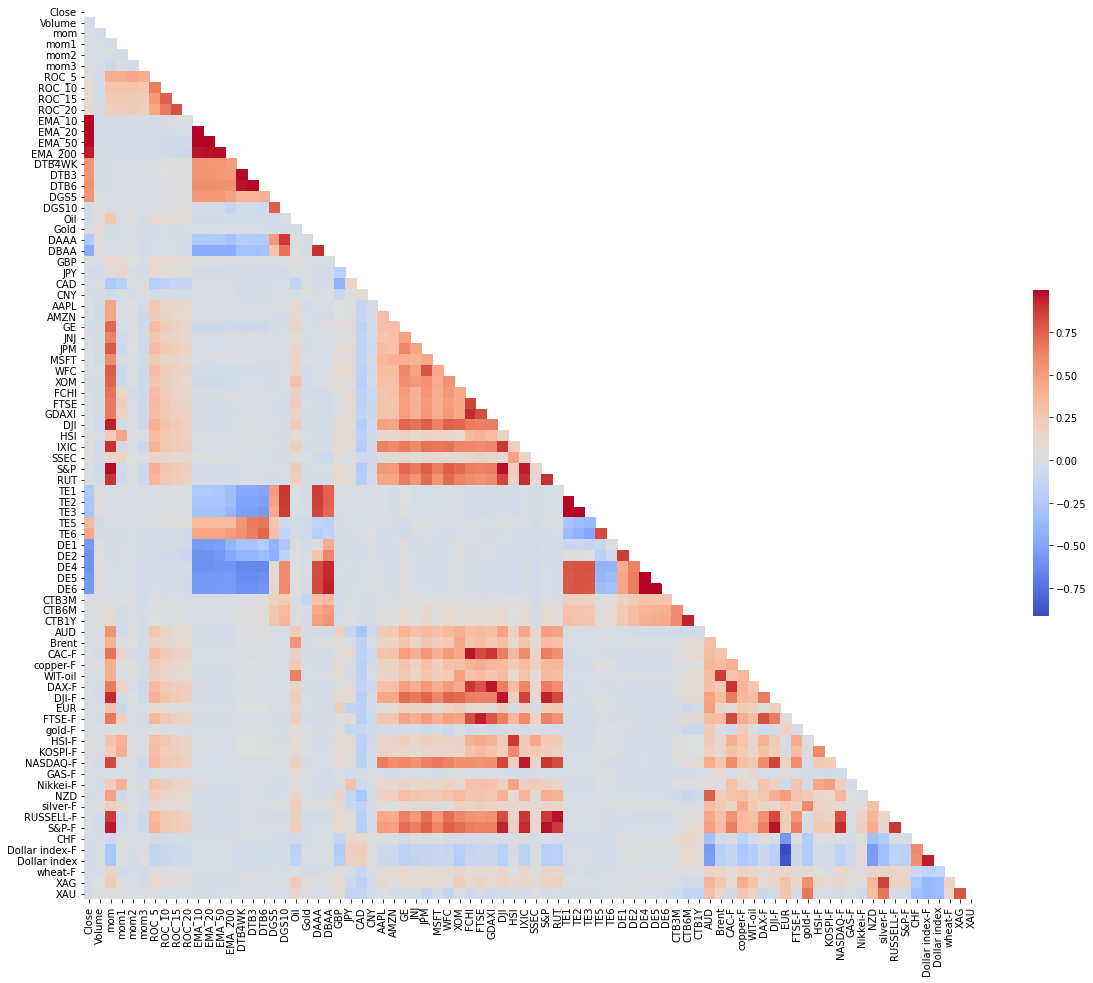

In [ ]:
## NYSE
corr_dji = nyse_df_full.drop(columns=["MOVEMENT"]).corr()
print(corr_dji["Close"].sort_values(ascending=False))
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)
mask=np.zeros_like(corr_dji)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_dji,
            xticklabels=corr_dji.columns,
            yticklabels=corr_dji.columns,
           ax=ax, mask=mask, square=True,
            cbar_kws={"shrink": 0.2},
           cmap="coolwarm")
plt.show()

Close      1.000000
EMA_10     0.997568
EMA_20     0.994999
EMA_50     0.988547
EMA_200    0.964507
             ...   
DE1       -0.509330
DE2       -0.570725
DE6       -0.578553
DE5       -0.591240
DE4       -0.612287
Name: Close, Length: 82, dtype: float64


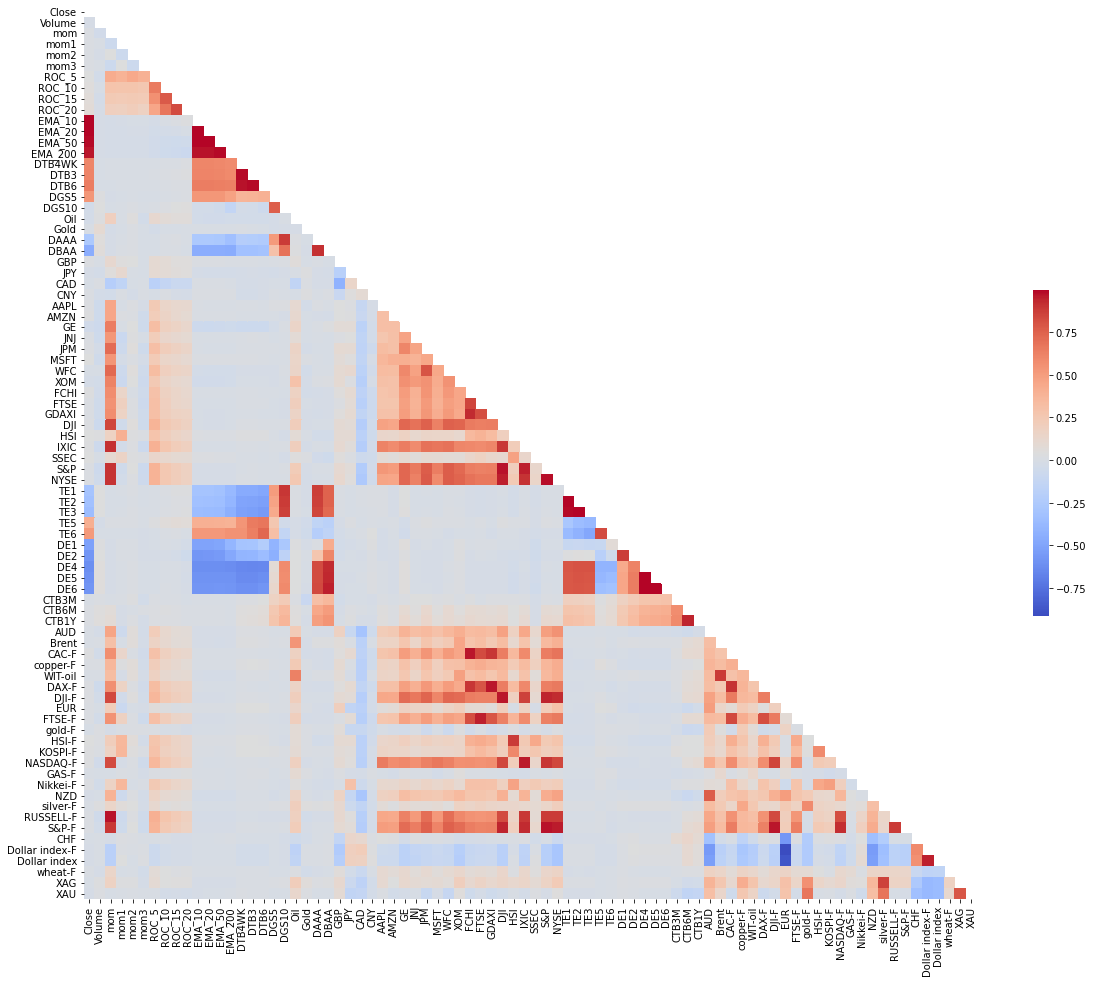

In [ ]:
## RUSSELL
corr_dji = russell_df_full.drop(columns=["MOVEMENT"]).corr()
print(corr_dji["Close"].sort_values(ascending=False))
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)
mask=np.zeros_like(corr_dji)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_dji,
            xticklabels=corr_dji.columns,
            yticklabels=corr_dji.columns,
           ax=ax, mask=mask, square=True,
            cbar_kws={"shrink": 0.2},
           cmap="coolwarm")
plt.show()

Close      1.000000
EMA_10     0.998865
EMA_20     0.997762
EMA_50     0.995229
EMA_200    0.986898
             ...   
DBAA      -0.484834
DE2       -0.503896
DE6       -0.620051
DE5       -0.633462
DE4       -0.659192
Name: Close, Length: 82, dtype: float64


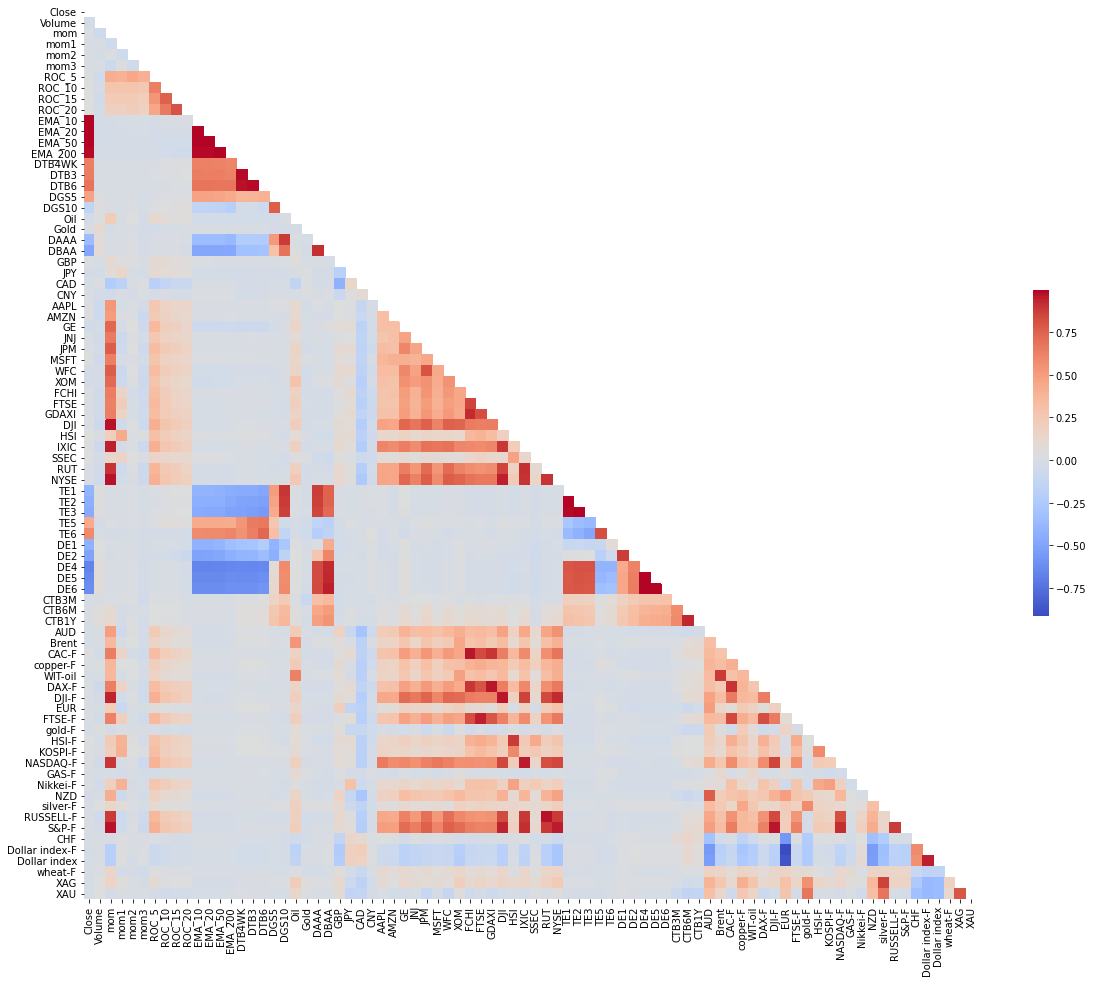

In [ ]:
## S&P 500
corr_dji = sp_df_full.drop(columns=["MOVEMENT"]).corr()
print(corr_dji["Close"].sort_values(ascending=False))
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)
mask=np.zeros_like(corr_dji)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_dji,
            xticklabels=corr_dji.columns,
            yticklabels=corr_dji.columns,
           ax=ax, mask=mask, square=True,
            cbar_kws={"shrink": 0.2},
           cmap="coolwarm")
plt.show()

**NOTING CLASS DISTRIBUTIONS**

In [ ]:
print('DJI VALUE COUNTS \n ',dji_df_full["MOVEMENT"].value_counts() ,' \n ')
print('nasdaq VALUE COUNTS \n ',nasdaq_df_full["MOVEMENT"].value_counts() ,' \n ')
print('nyse VALUE COUNTS \n ',nyse_df_full["MOVEMENT"].value_counts() ,' \n ')
print('russell VALUE COUNTS \n ',russell_df_full["MOVEMENT"].value_counts(),' \n ')
print('sp VALUE COUNTS \n ',sp_df_full["MOVEMENT"].value_counts(),' \n ' )

DJI VALUE COUNTS 
  1    961
0    822
Name: MOVEMENT, dtype: int64  
 
nasdaq VALUE COUNTS 
  1    998
0    785
Name: MOVEMENT, dtype: int64  
 
nyse VALUE COUNTS 
  1    954
0    829
Name: MOVEMENT, dtype: int64  
 
russell VALUE COUNTS 
  1    953
0    830
Name: MOVEMENT, dtype: int64  
 
sp VALUE COUNTS 
  1    973
0    810
Name: MOVEMENT, dtype: int64  
 


In [ ]:
# Class distribution plot
dji_class = dji_df_full[["MOVEMENT"]]
dji_class["dataset_name"] = ["DJI" for i in range(dji_df_full.shape[0])]

nasdaq_class = nasdaq_df_full[["MOVEMENT"]]
nasdaq_class["dataset_name"] = ["NASDAQ" for i in range(dji_df_full.shape[0])]

nyse_class = nyse_df_full[["MOVEMENT"]]
nyse_class["dataset_name"] = ["NYSE" for i in range(dji_df_full.shape[0])]

russell_class = russell_df_full[["MOVEMENT"]]
russell_class["dataset_name"] = ["RUSSELL" for i in range(dji_df_full.shape[0])]

sp_class = sp_df_full[["MOVEMENT"]]
sp_class["dataset_name"] = ["S&P 500" for i in range(dji_df_full.shape[0])]

# Concatenate
merge_df = pd.concat([dji_class, nasdaq_class, nyse_class, russell_class, sp_class], ignore_index=True)


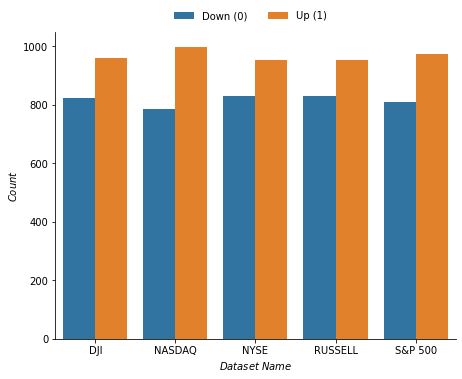

In [ ]:
g = sns.catplot(x='dataset_name', hue='MOVEMENT', 
            kind='count', data=merge_df, ci=False, aspect=1.3,
               legend=False)
plt.xlabel("$Dataset$ $Name$")
plt.ylabel("$Count$")
plt.legend(labels=["Down (0)", "Up (1)"],
          bbox_to_anchor=[0.7,1.1], ncol=2, frameon=False)

plt.show()

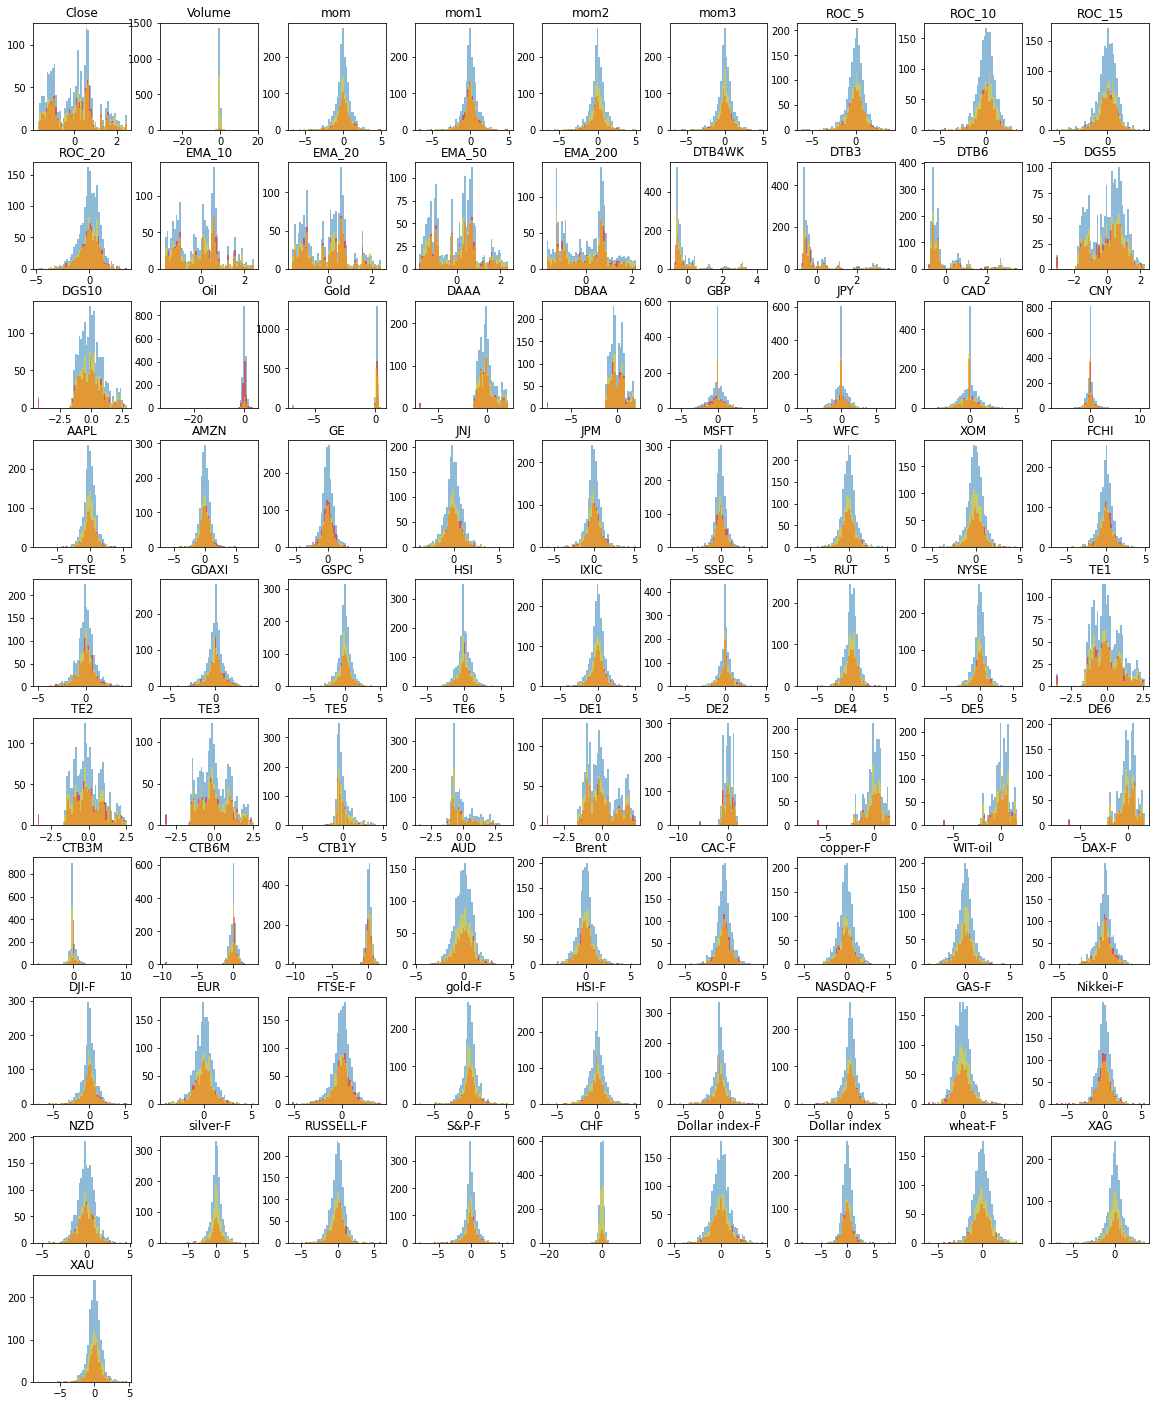

In [ ]:
## DJI NASDAQ, ETC
ax = dji_df_full.drop(columns=["MOVEMENT"]).hist(bins=50, alpha=0.5, label="Full", grid=False, figsize=(20, 25))
dji_df_full[dji_df_full["MOVEMENT"] == 0].hist(bins=50, ax=ax.ravel()[:83],grid=False, color="r", alpha=0.5, label="Down")
dji_df_full[dji_df_full["MOVEMENT"] == 1].hist(bins=50, ax=ax.ravel()[:83], color="gold",grid=False, alpha=0.5, label="Up")
plt.show()

##Feature selection wrt to labels



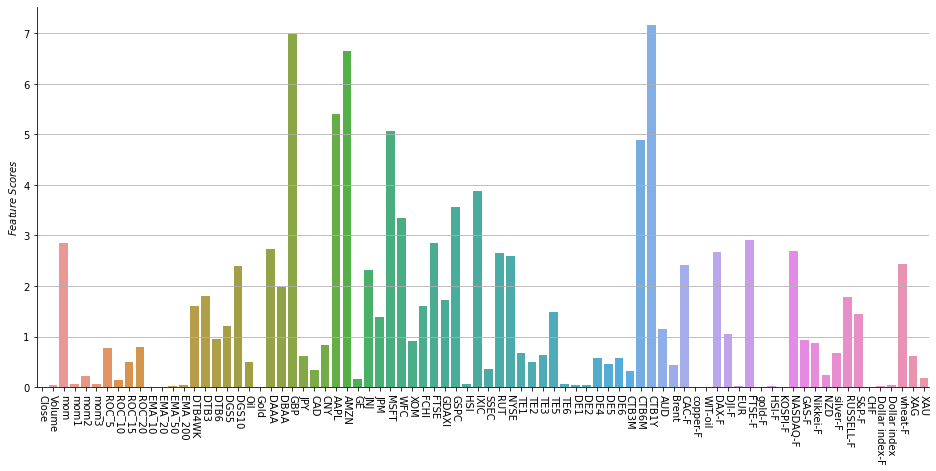

In [ ]:
fs = SelectKBest(score_func=f_classif)
X_selected = fs.fit_transform(dji_df_full.drop(columns=["MOVEMENT"]), dji_df_full["MOVEMENT"])

y = fs.scores_
x = dji_df_full.drop(columns=["MOVEMENT"]).columns

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111)
sns.barplot(x=x, y=y, ax=ax)
plt.xticks(rotation=-90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("$Feature$ $Scores$")
plt.grid(axis="y")
plt.show()

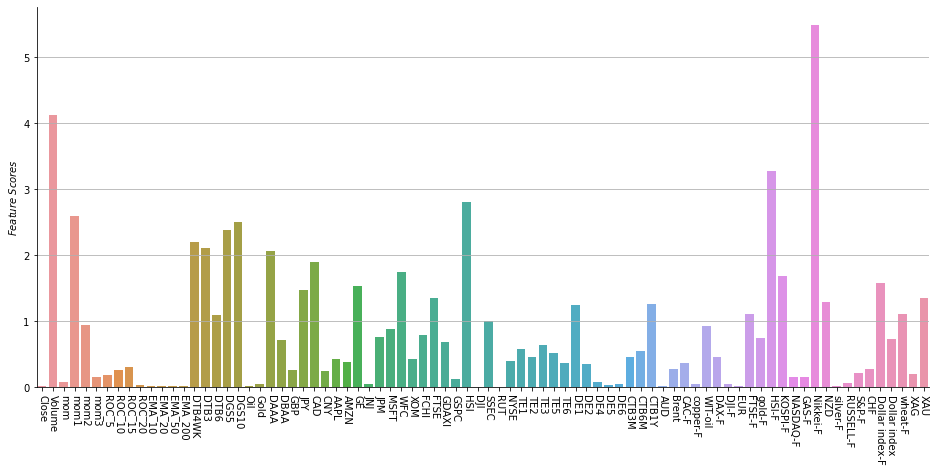

In [ ]:
## NASDAQ
fs = SelectKBest(score_func=f_classif)
X_selected = fs.fit_transform(nasdaq_df_full.drop(columns=["MOVEMENT"]), nasdaq_df_full["MOVEMENT"])
y = fs.scores_
x = nasdaq_df_full.drop(columns=["MOVEMENT"]).columns
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111)
sns.barplot(x=x, y=y, ax=ax)
plt.xticks(rotation=-90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("$Feature$ $Scores$")
plt.grid(axis="y")
plt.show()

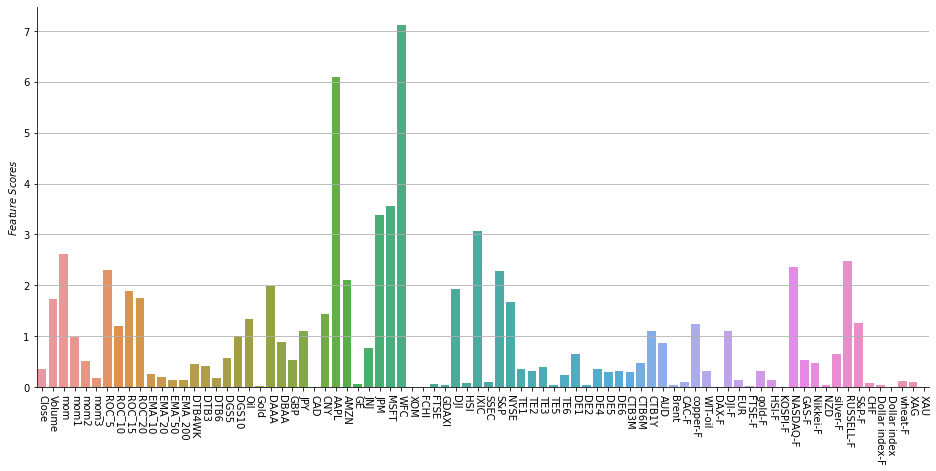

In [ ]:
## RUSSELL
fs = SelectKBest(score_func=f_classif)
X_selected = fs.fit_transform(russell_df_full.drop(columns=["MOVEMENT"]), russell_df_full["MOVEMENT"])
y = fs.scores_
x = russell_df_full.drop(columns=["MOVEMENT"]).columns
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111)
sns.barplot(x=x, y=y, ax=ax)
plt.xticks(rotation=-90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("$Feature$ $Scores$")
plt.grid(axis="y")
plt.show()

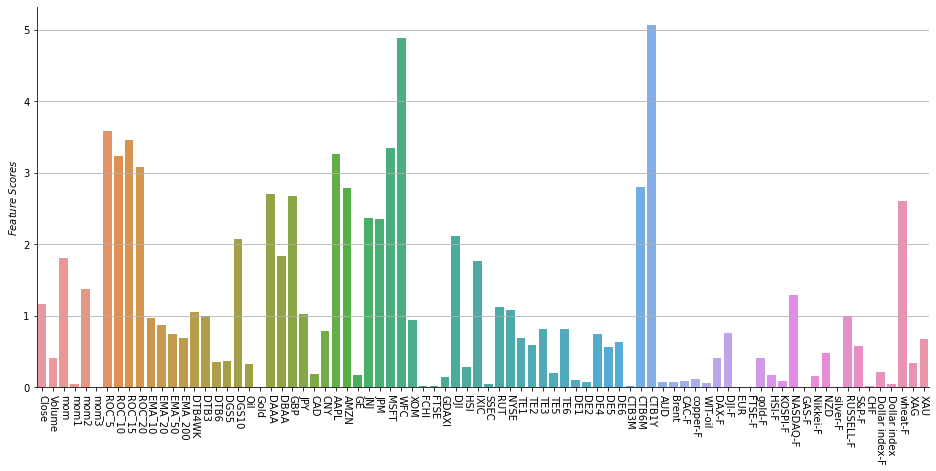

In [ ]:
## S&P 500
fs = SelectKBest(score_func=f_classif)
X_selected = fs.fit_transform(sp_df_full.drop(columns=["MOVEMENT"]), sp_df_full["MOVEMENT"])
y = fs.scores_
x = sp_df_full.drop(columns=["MOVEMENT"]).columns
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111)
sns.barplot(x=x, y=y, ax=ax)
plt.xticks(rotation=-90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("$Feature$ $Scores$")
plt.grid(axis="y")
plt.show()

##Time Series Data Exploration

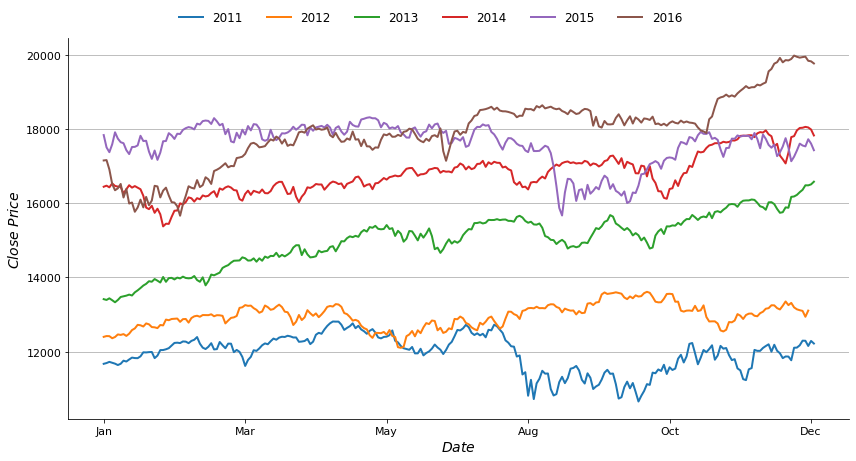

In [ ]:
## DJI
dji_df_time = dji_df.copy()
dji_df_time.fillna(0, inplace=True)
df1 = dji_df_time.loc["2011":"2012"]["Close"].copy().reset_index()["Close"]
df2 = dji_df_time.loc["2012":"2013"]["Close"].copy().reset_index()["Close"]
df3 = dji_df_time.loc["2013":"2014"]["Close"].copy().reset_index()["Close"]
df4 = dji_df_time.loc["2014":"2015"]["Close"].copy().reset_index()["Close"]
df5 = dji_df_time.loc["2015":"2016"]["Close"].copy().reset_index()["Close"]
df6 = dji_df_time.loc["2016":"2017"]["Close"].copy().reset_index()["Close"]
plt.figure(figsize=(14, 7))
ax = df1.plot(lw=2)
df2.plot(ax=ax, lw=2)
df3.plot(ax=ax, lw=2)
df4.plot(ax=ax, lw=2)
df5.plot(ax=ax, lw=2)
df6.plot(ax=ax, lw=2)
plt.xticks(np.arange(0, 252, 50), labels=["Jan", "Mar", "May", "Aug", "Oct", "Dec"])
ax.legend(["2011", "2012", "2013", "2014", "2015", "2016"],
         bbox_to_anchor=[0.8,1.1], ncol=6, frameon=False, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel("$Date$", fontsize=14)
ax.set_ylabel("$Close$ $Price$", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(axis="y")
plt.show()

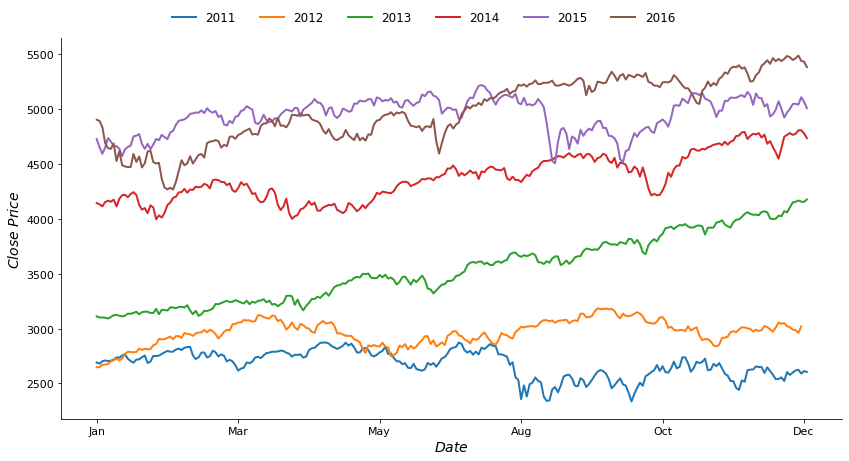

In [ ]:
## NASDAQ
dji_df_time = nasdaq_df.copy()
dji_df_time.fillna(0, inplace=True)
df1 = dji_df_time.loc["2011":"2012"]["Close"].copy().reset_index()["Close"]
df2 = dji_df_time.loc["2012":"2013"]["Close"].copy().reset_index()["Close"]
df3 = dji_df_time.loc["2013":"2014"]["Close"].copy().reset_index()["Close"]
df4 = dji_df_time.loc["2014":"2015"]["Close"].copy().reset_index()["Close"]
df5 = dji_df_time.loc["2015":"2016"]["Close"].copy().reset_index()["Close"]
df6 = dji_df_time.loc["2016":"2017"]["Close"].copy().reset_index()["Close"]
plt.figure(figsize=(14, 7))
ax = df1.plot(lw=2)
df2.plot(ax=ax, lw=2)
df3.plot(ax=ax, lw=2)
df4.plot(ax=ax, lw=2)
df5.plot(ax=ax, lw=2)
df6.plot(ax=ax, lw=2)
plt.xticks(np.arange(0, 252, 50), labels=["Jan", "Mar", "May", "Aug", "Oct", "Dec"])
ax.legend(["2011", "2012", "2013", "2014", "2015", "2016"],
         bbox_to_anchor=[0.8,1.1], ncol=6, frameon=False, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel("$Date$", fontsize=14)
ax.set_ylabel("$Close$ $Price$", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

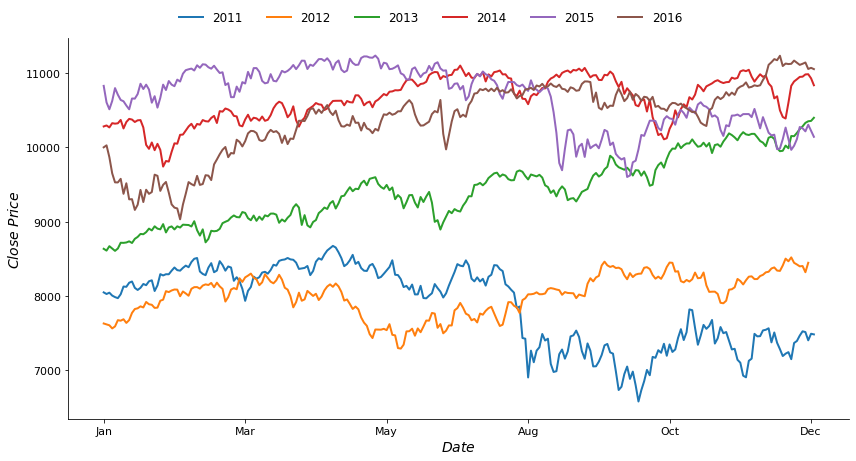

In [ ]:
## NYSE
dji_df_time = nyse_df.copy()
dji_df_time.fillna(0, inplace=True)
df1 = dji_df_time.loc["2011":"2012"]["Close"].copy().reset_index()["Close"]
df2 = dji_df_time.loc["2012":"2013"]["Close"].copy().reset_index()["Close"]
df3 = dji_df_time.loc["2013":"2014"]["Close"].copy().reset_index()["Close"]
df4 = dji_df_time.loc["2014":"2015"]["Close"].copy().reset_index()["Close"]
df5 = dji_df_time.loc["2015":"2016"]["Close"].copy().reset_index()["Close"]
df6 = dji_df_time.loc["2016":"2017"]["Close"].copy().reset_index()["Close"]
plt.figure(figsize=(14, 7))
ax = df1.plot(lw=2)
df2.plot(ax=ax, lw=2)
df3.plot(ax=ax, lw=2)
df4.plot(ax=ax, lw=2)
df5.plot(ax=ax, lw=2)
df6.plot(ax=ax, lw=2)
plt.xticks(np.arange(0, 252, 50), labels=["Jan", "Mar", "May", "Aug", "Oct", "Dec"])
ax.legend(["2011", "2012", "2013", "2014", "2015", "2016"],
         bbox_to_anchor=[0.8,1.1], ncol=6, frameon=False, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel("$Date$", fontsize=14)
ax.set_ylabel("$Close$ $Price$", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

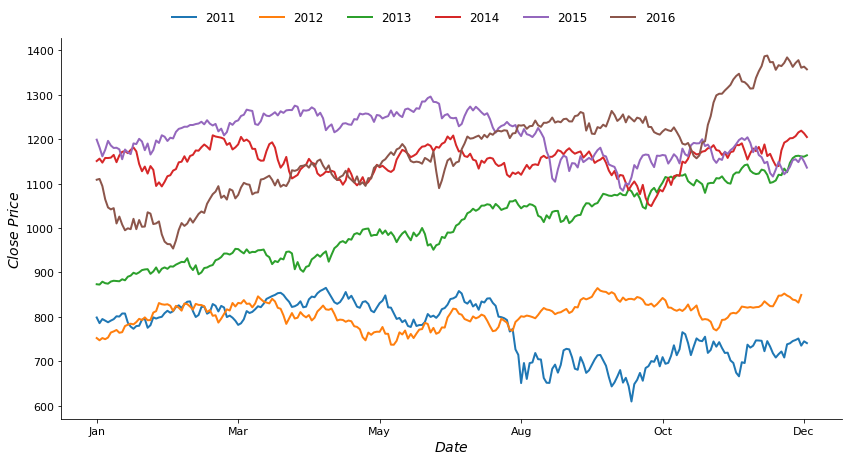

In [ ]:
##russell
dji_df_time = russell_df.copy()
dji_df_time.fillna(0, inplace=True)
df1 = dji_df_time.loc["2011":"2012"]["Close"].copy().reset_index()["Close"]
df2 = dji_df_time.loc["2012":"2013"]["Close"].copy().reset_index()["Close"]
df3 = dji_df_time.loc["2013":"2014"]["Close"].copy().reset_index()["Close"]
df4 = dji_df_time.loc["2014":"2015"]["Close"].copy().reset_index()["Close"]
df5 = dji_df_time.loc["2015":"2016"]["Close"].copy().reset_index()["Close"]
df6 = dji_df_time.loc["2016":"2017"]["Close"].copy().reset_index()["Close"]
plt.figure(figsize=(14, 7))
ax = df1.plot(lw=2)
df2.plot(ax=ax, lw=2)
df3.plot(ax=ax, lw=2)
df4.plot(ax=ax, lw=2)
df5.plot(ax=ax, lw=2)
df6.plot(ax=ax, lw=2)
plt.xticks(np.arange(0, 252, 50), labels=["Jan", "Mar", "May", "Aug", "Oct", "Dec"])
ax.legend(["2011", "2012", "2013", "2014", "2015", "2016"],
         bbox_to_anchor=[0.8,1.1], ncol=6, frameon=False, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel("$Date$", fontsize=14)
ax.set_ylabel("$Close$ $Price$", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

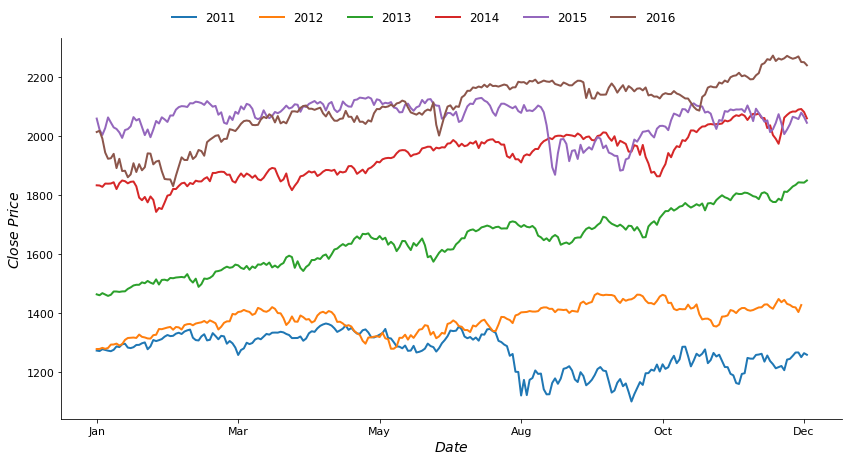

In [ ]:
## s&p 500
dji_df_time = sp_df.copy()
dji_df_time.fillna(0, inplace=True)
df1 = dji_df_time.loc["2011":"2012"]["Close"].copy().reset_index()["Close"]
df2 = dji_df_time.loc["2012":"2013"]["Close"].copy().reset_index()["Close"]
df3 = dji_df_time.loc["2013":"2014"]["Close"].copy().reset_index()["Close"]
df4 = dji_df_time.loc["2014":"2015"]["Close"].copy().reset_index()["Close"]
df5 = dji_df_time.loc["2015":"2016"]["Close"].copy().reset_index()["Close"]
df6 = dji_df_time.loc["2016":"2017"]["Close"].copy().reset_index()["Close"]
plt.figure(figsize=(14, 7))
ax = df1.plot(lw=2)
df2.plot(ax=ax, lw=2)
df3.plot(ax=ax, lw=2)
df4.plot(ax=ax, lw=2)
df5.plot(ax=ax, lw=2)
df6.plot(ax=ax, lw=2)
plt.xticks(np.arange(0, 252, 50), labels=["Jan", "Mar", "May", "Aug", "Oct", "Dec"])
ax.legend(["2011", "2012", "2013", "2014", "2015", "2016"],
         bbox_to_anchor=[0.8,1.1], ncol=6, frameon=False, prop={"size":12})
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel("$Date$", fontsize=14)
ax.set_ylabel("$Close$ $Price$", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

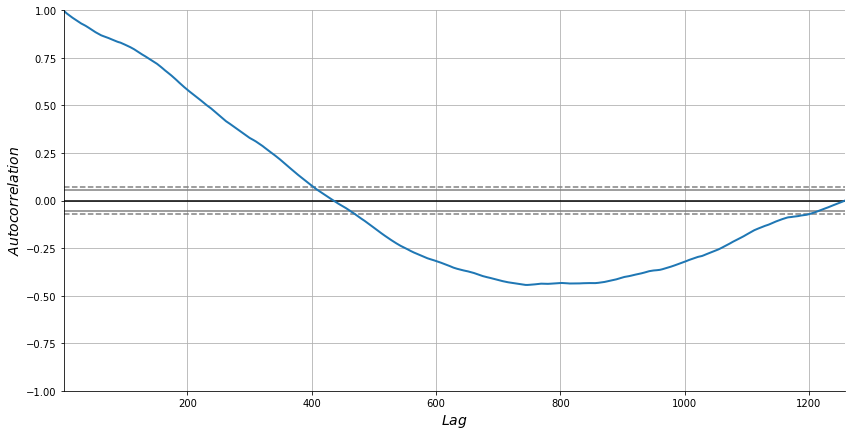

In [ ]:
#Auto CORRELATION PLOT

## DJI, NASDAQ, ETC
fig = plt.figure(figsize=(14, 7))
dji_df_time = dji_df.copy()
dji_df_time.fillna(0, inplace=True)
ax = pd.plotting.autocorrelation_plot(dji_df_time["2011":"2016"]["Close"], lw=2)
ax.set_xlabel("$Lag$", fontsize=14)
ax.set_ylabel("$Autocorrelation$", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

#Expiriemtn ing 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers, models, backend as K, callbacks

##LOADING AND PREPROCESSING AGAIN:: MIGHT HAVE USED THE SAME VARIABLES AGAIN

In [ ]:
# Load datasets
## DJI
dji_df = aggregated_datasets["DJI"]

## NASDAQ
nasdaq_df = aggregated_datasets["NASDAQ"]

## NYSE
nyse_df = aggregated_datasets["NYA"]

## Russell
russell_df = aggregated_datasets["RUT"]

## SP
sp_df = aggregated_datasets["S&P"]

# Build sequential dataset
sequence_length = 60

### Sequential dataset (full features)
dji_X_seq, dji_y_seq = generate_sequential_data(dji_df_full, sequence_length)
nasdaq_X_seq, nasdaq_y_seq = generate_sequential_data(nasdaq_df_full, sequence_length)
nyse_X_seq, nyse_y_seq = generate_sequential_data(nyse_df_full, sequence_length)
russell_X_seq, russell_y_seq = generate_sequential_data(russell_df_full, sequence_length)
sp_X_seq, sp_y_seq = generate_sequential_data(sp_df_full, sequence_length)



########################################################################
#DATA PRE PROC
##########################################################################
# Sequential flatten (full features)
dji_X_seq_flatten = sequential_reshape(dji_X_seq, (len(dji_X_seq), -1))
nasdaq_X_seq_flatten = sequential_reshape(nasdaq_X_seq, (len(nasdaq_X_seq), -1))
nyse_X_seq_flatten = sequential_reshape(nyse_X_seq, (len(nyse_X_seq), -1))
russell_X_seq_flatten = sequential_reshape(russell_X_seq, (len(russell_X_seq), -1))
sp_X_seq_flatten = sequential_reshape(sp_X_seq, (len(sp_X_seq), -1))
# Split into training, validation, and test set.
# It should be noted that we should not shuffle to prevent
# cheating the value of an index from data from other index
# on the same date.
dji_X_train_full, dji_X_test_full, dji_y_train_full, dji_y_test_full = train_test_split(dji_X_seq_flatten,
                                                                                        dji_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
dji_X_train_full, dji_X_valid_full, dji_y_train_full, dji_y_valid_full = train_test_split(dji_X_train_full,
                                                                                        dji_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nasdaq_X_train_full, nasdaq_X_test_full, nasdaq_y_train_full, nasdaq_y_test_full = train_test_split(nasdaq_X_seq_flatten,
                                                                                        nasdaq_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nasdaq_X_train_full, nasdaq_X_valid_full, nasdaq_y_train_full, nasdaq_y_valid_full = train_test_split(nasdaq_X_train_full,
                                                                                        nasdaq_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nyse_X_train_full, nyse_X_test_full, nyse_y_train_full, nyse_y_test_full = train_test_split(nyse_X_seq_flatten,
                                                                                        nyse_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, 
                                                                                        shuffle=False)
nyse_X_train_full, nyse_X_valid_full, nyse_y_train_full, nyse_y_valid_full = train_test_split(nyse_X_train_full,
                                                                                        nyse_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, 
                                                                                        shuffle=False)
russell_X_train_full, russell_X_test_full, russell_y_train_full, russell_y_test_full = train_test_split(russell_X_seq_flatten,
                                                                                        russell_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, 
                                                                                        shuffle=False)
russell_X_train_full, russell_X_valid_full, russell_y_train_full, russell_y_valid_full = train_test_split(russell_X_train_full,
                                                                                        russell_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, 
                                                                                        shuffle=False)
sp_X_train_full, sp_X_test_full, sp_y_train_full, sp_y_test_full = train_test_split(sp_X_seq_flatten,
                                                                                        sp_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
sp_X_train_full, sp_X_valid_full, sp_y_train_full, sp_y_valid_full = train_test_split(sp_X_train_full,
                                                                                        sp_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, 
                                                                                        shuffle=False)

In [ ]:
# Merge indices into one (training)
X_train_full = np.concatenate(
    (dji_X_train_full,
     nasdaq_X_train_full,
     nyse_X_train_full,
     russell_X_train_full,
     sp_X_train_full)
)

y_train_full = np.concatenate(
    (np.array(dji_y_train_full),
     np.array(nasdaq_y_train_full),
     np.array(nyse_y_train_full),
     np.array(russell_y_train_full),
     np.array(sp_y_train_full))
)

# Validation
X_valid_full = np.concatenate(
    (dji_X_valid_full,
     nasdaq_X_valid_full,
     nyse_X_valid_full,
     russell_X_valid_full,
     sp_X_valid_full)
)

y_valid_full = np.concatenate(
    (np.array(dji_y_valid_full),
     np.array(nasdaq_y_valid_full),
     np.array(nyse_y_valid_full),
     np.array(russell_y_valid_full),
     np.array(sp_y_valid_full))
)


#Perform and visualise random search result.

param_grid = {
    "C": np.random.uniform(1, 100, 20),
    "solver": ["lbfgs", "saga", "sag"],
    "fit_intercept": [True, False]
}

dict_result = {"C": [], "solver": [], "fit_intercept": [],
              "accuracy": [], "f1": []} # store grid search result


param_grid["C"] = list(param_grid["C"])
param_grid["C"].append(1) # Add default value
# Search over params on the param_grid
for c in tqdm(param_grid["C"]):
    for solver in param_grid["solver"]:
        for intercept in param_grid["fit_intercept"]:
            print(f"C: {c}, solver: {solver}, fit_intercept:{intercept}")
            dict_result["C"].append(c)
            dict_result["solver"].append(solver)
            dict_result["fit_intercept"].append(intercept)
            
            # Build logistic regression
            lr = LogisticRegression(C=c, fit_intercept=intercept, solver=solver)
            lr.fit(X_train_full, y_train_full)
            
            pred = lr.predict(X_valid_full)
            print(f"Accuracy: {accuracy_score(pred, y_valid_full)}")            
            print(f"Macro F1: {f1_score(pred, y_valid_full, average='macro')}")
            print("*"*50, "\n")
            dict_result["accuracy"].append(accuracy_score(pred, y_valid_full))
            dict_result["f1"].append(f1_score(pred, y_valid_full, average='macro'))

##Feedforward network 


In [ ]:
# Sequential flatten (full features)
dji_X_seq_flatten = sequential_reshape(dji_X_seq, (len(dji_X_seq), -1))
nasdaq_X_seq_flatten = sequential_reshape(nasdaq_X_seq, (len(nasdaq_X_seq), -1))
nyse_X_seq_flatten = sequential_reshape(nyse_X_seq, (len(nyse_X_seq), -1))
russell_X_seq_flatten = sequential_reshape(russell_X_seq, (len(russell_X_seq), -1))
sp_X_seq_flatten = sequential_reshape(sp_X_seq, (len(sp_X_seq), -1))

#Split into training/validation/test (80/10/10)
## Full features


dji_X_train_full, dji_X_test_full, dji_y_train_full, dji_y_test_full = train_test_split(dji_X_seq_flatten,
                                                                                        dji_y_seq,
                                                                                        stratify=dji_y_seq,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
dji_X_train_full, dji_X_valid_full, dji_y_train_full, dji_y_valid_full = train_test_split(dji_X_train_full,
                                                                                        dji_y_train_full,
                                                                                        stratify=dji_y_train_full,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
nasdaq_X_train_full, nasdaq_X_test_full, nasdaq_y_train_full, nasdaq_y_test_full = train_test_split(nasdaq_X_seq_flatten,
                                                                                        nasdaq_y_seq,
                                                                                        stratify=nasdaq_y_seq,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
nasdaq_X_train_full, nasdaq_X_valid_full, nasdaq_y_train_full, nasdaq_y_valid_full = train_test_split(nasdaq_X_train_full,
                                                                                        nasdaq_y_train_full,
                                                                                        stratify=nasdaq_y_train_full,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
nyse_X_train_full, nyse_X_test_full, nyse_y_train_full, nyse_y_test_full = train_test_split(nyse_X_seq_flatten,
                                                                                        nyse_y_seq,
                                                                                        stratify=nyse_y_seq,
                                                                                        test_size=0.1, shuffle=True)
nyse_X_train_full, nyse_X_valid_full, nyse_y_train_full, nyse_y_valid_full = train_test_split(nyse_X_train_full,
                                                                                        nyse_y_train_full,
                                                                                        stratify=nyse_y_train_full,
                                                                                        test_size=0.1, shuffle=True)

russell_X_train_full, russell_X_test_full, russell_y_train_full, russell_y_test_full = train_test_split(russell_X_seq_flatten,
                                                                                        russell_y_seq,
                                                                                        stratify=russell_y_seq,
                                                                                        test_size=0.1, shuffle=True)
russell_X_train_full, russell_X_valid_full, russell_y_train_full, russell_y_valid_full = train_test_split(russell_X_train_full,
                                                                                        russell_y_train_full,
                                                                                        stratify=russell_y_train_full,
                                                                                        test_size=0.1, shuffle=True)
sp_X_train_full, sp_X_test_full, sp_y_train_full, sp_y_test_full = train_test_split(sp_X_seq_flatten,
                                                                                        sp_y_seq,
                                                                                        stratify=sp_y_seq,
                                                                                        test_size=0.1, shuffle=True)
sp_X_train_full, sp_X_valid_full, sp_y_train_full, sp_y_valid_full = train_test_split(sp_X_train_full,
                                                                                        sp_y_train_full,
                                                                                        stratify=sp_y_train_full,
                                                                                        test_size=0.1, shuffle=True)

training and EVAL


In [ ]:
## DJI
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(dji_X_train_full, np.array(dji_y_train_full), 
          epochs=100, batch_size=32,
          validation_data=(dji_X_valid_full, np.array(dji_y_valid_full)), callbacks=[early_stopping])

result_dji_full = model.predict(dji_X_test_full)
result_dji_full = (result_dji_full > 0.5).astype(int)
print(f"DJI Accuracy: {accuracy_score(result_dji_full, dji_y_test_full)}")
print(f"DJI F1: {f1_score(result_dji_full, dji_y_test_full, average='macro')}")

Epoch 1/100
44/44 [==============================] - 2s 10ms/step - loss: 2.4131 - acc: 0.4961 - f1: 0.4698 - val_loss: 1.3907 - val_acc: 0.4679 - val_f1: 0.4658
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.8403 - acc: 0.6136 - f1: 0.6001 - val_loss: 0.8666 - val_acc: 0.4167 - val_f1: 0.4165
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.4550 - acc: 0.7799 - f1: 0.7698 - val_loss: 1.0086 - val_acc: 0.4808 - val_f1: 0.4796
Epoch 4/100
44/44 [==============================] - 0s 4ms/step - loss: 0.3647 - acc: 0.8158 - f1: 0.8060 - val_loss: 1.0101 - val_acc: 0.4936 - val_f1: 0.4904
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1948 - acc: 0.9147 - f1: 0.9109 - val_loss: 1.3208 - val_acc: 0.4936 - val_f1: 0.4852
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1169 - acc: 0.9548 - f1: 0.9533 - val_loss: 1.6502 - val_acc: 0.4744 - val_f1: 0.4637
Epoch 7/100
44/44 [==============

In [ ]:
## NASDAQ
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(nasdaq_X_train_full, np.array(nasdaq_y_train_full), 
          epochs=100, batch_size=128,
          validation_data=(nasdaq_X_valid_full, np.array(nasdaq_y_valid_full)), callbacks=[early_stopping])

## NASDAQ
result_nasdaq_full = model.predict(nasdaq_X_test_full)
result_nasdaq_full = (result_nasdaq_full > 0.5).astype(int)
print(f"NASDAQ Accuracy: {accuracy_score(result_nasdaq_full, nasdaq_y_test_full)}")
print(f"NASDAQ F1: {f1_score(result_nasdaq_full, nasdaq_y_test_full, average='macro')}")

Epoch 1/100
11/11 [==============================] - 1s 32ms/step - loss: 0.8503 - acc: 0.5211 - f1: 0.5094 - val_loss: 0.8380 - val_acc: 0.4872 - val_f1: 0.5269
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4242 - acc: 0.8143 - f1: 0.8072 - val_loss: 0.8378 - val_acc: 0.5641 - val_f1: 0.5780
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2494 - acc: 0.9384 - f1: 0.9366 - val_loss: 0.9190 - val_acc: 0.5256 - val_f1: 0.5281
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1478 - acc: 0.9842 - f1: 0.9839 - val_loss: 0.9907 - val_acc: 0.5256 - val_f1: 0.5227
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0885 - acc: 0.9950 - f1: 0.9948 - val_loss: 1.1136 - val_acc: 0.5321 - val_f1: 0.5449
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0528 - acc: 0.9986 - f1: 0.9986 - val_loss: 1.1400 - val_acc: 0.5064 - val_f1: 0.5136
Epoch 7/100
11/11 [==============

In [ ]:
## NYSE
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(nyse_X_train_full, np.array(nyse_y_train_full), 
          epochs=100, batch_size=32,
          validation_data=(nyse_X_valid_full, np.array(nyse_y_valid_full)), callbacks=[early_stopping])

## NYSE
result_nyse_full = model.predict(nyse_X_test_full)
result_nyse_full = (result_nyse_full > 0.5).astype(int)
print(f"NYSE Accuracy: {accuracy_score(result_nyse_full, nyse_y_test_full)}")
print(f"NYSE F1: {f1_score(result_nyse_full, nyse_y_test_full, average='macro')}")

Epoch 1/100
44/44 [==============================] - 1s 9ms/step - loss: 0.8581 - acc: 0.5168 - f1: 0.5007 - val_loss: 0.8736 - val_acc: 0.4615 - val_f1: 0.4560
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.4456 - acc: 0.8086 - f1: 0.8022 - val_loss: 0.9559 - val_acc: 0.5000 - val_f1: 0.4942
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.2477 - acc: 0.9211 - f1: 0.9184 - val_loss: 0.9859 - val_acc: 0.5256 - val_f1: 0.5174
Epoch 4/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1120 - acc: 0.9871 - f1: 0.9871 - val_loss: 1.1532 - val_acc: 0.4423 - val_f1: 0.4355
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0448 - acc: 1.0000 - f1: 1.0000 - val_loss: 1.2490 - val_acc: 0.4487 - val_f1: 0.4434
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0230 - acc: 1.0000 - f1: 1.0000 - val_loss: 1.4055 - val_acc: 0.4231 - val_f1: 0.4191
Epoch 7/100
44/44 [===============

In [ ]:
## Russell
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(russell_X_train_full, np.array(russell_y_train_full), 
          epochs=100, batch_size=128,
          validation_data=(russell_X_valid_full, np.array(russell_y_valid_full)), callbacks=[early_stopping])

## russell
result_russell_full = model.predict(nyse_X_test_full)
result_russell_full = (result_russell_full > 0.5).astype(int)
print(f"russell Accuracy: {accuracy_score(result_russell_full, russell_y_test_full)}")
print(f"russell F1: {f1_score(result_russell_full, russell_y_test_full, average='macro')}")

Epoch 1/100
11/11 [==============================] - 1s 32ms/step - loss: 0.8282 - acc: 0.5168 - f1: 0.5076 - val_loss: 0.8729 - val_acc: 0.4808 - val_f1: 0.4013
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4323 - acc: 0.8244 - f1: 0.8200 - val_loss: 0.8452 - val_acc: 0.4872 - val_f1: 0.4142
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2602 - acc: 0.9419 - f1: 0.9408 - val_loss: 0.9096 - val_acc: 0.5256 - val_f1: 0.4430
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1531 - acc: 0.9799 - f1: 0.9798 - val_loss: 0.9830 - val_acc: 0.5064 - val_f1: 0.4111
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0892 - acc: 0.9943 - f1: 0.9943 - val_loss: 1.0395 - val_acc: 0.4744 - val_f1: 0.4239
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0535 - acc: 0.9993 - f1: 0.9993 - val_loss: 1.1739 - val_acc: 0.4551 - val_f1: 0.3789
Epoch 7/100
11/11 [==============

In [ ]:
## S&P 500
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(sp_X_train_full, np.array(sp_y_train_full), 
          epochs=100, batch_size=128,
          validation_data=(sp_X_valid_full, np.array(sp_y_valid_full)), callbacks=[early_stopping])

## russell
result_sp_full = model.predict(nyse_X_test_full)
result_sp_full = (result_sp_full > 0.5).astype(int)
print(f"NYSE Accuracy: {accuracy_score(result_sp_full, sp_y_test_full)}")
print(f"NYSE F1: {f1_score(result_sp_full, sp_y_test_full, average='macro')}")

Epoch 1/100
11/11 [==============================] - 1s 31ms/step - loss: 0.8315 - acc: 0.5068 - f1: 0.4926 - val_loss: 0.8023 - val_acc: 0.5577 - val_f1: 0.5416
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4402 - acc: 0.8093 - f1: 0.8053 - val_loss: 0.8191 - val_acc: 0.5641 - val_f1: 0.4988
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2584 - acc: 0.9391 - f1: 0.9376 - val_loss: 0.8167 - val_acc: 0.5769 - val_f1: 0.5264
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1415 - acc: 0.9857 - f1: 0.9855 - val_loss: 0.9141 - val_acc: 0.5000 - val_f1: 0.4714
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0788 - acc: 0.9978 - f1: 0.9977 - val_loss: 0.9946 - val_acc: 0.5128 - val_f1: 0.4794
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0463 - acc: 0.9986 - f1: 0.9985 - val_loss: 1.0495 - val_acc: 0.5385 - val_f1: 0.5029
Epoch 7/100
11/11 [==============

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

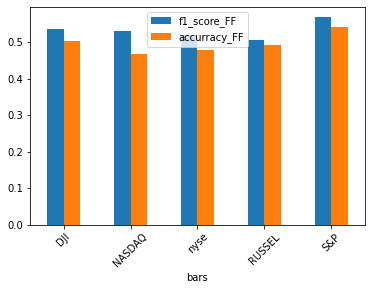

In [ ]:
accurracy_FF=[accuracy_score(result_dji_full, dji_y_test_full),accuracy_score(result_nasdaq_full, nasdaq_y_test_full),accuracy_score(result_nyse_full, nyse_y_test_full),accuracy_score(result_russell_full, russell_y_test_full),accuracy_score(result_sp_full, sp_y_test_full)]
f1_score_FF=[f1_score(result_dji_full, dji_y_test_full),f1_score(result_nasdaq_full, nasdaq_y_test_full),f1_score(result_nyse_full, nyse_y_test_full),f1_score(result_russell_full, russell_y_test_full),f1_score(result_sp_full, sp_y_test_full)]

new_zip=(f1_score_FF,accurracy_FF)
bars=['DJI','NASDAQ','nyse','RUSSEL','S&P']

raw=pd.DataFrame({
    'bars':bars,
    'f1_score_FF':f1_score_FF,
     'accurracy_FF':accurracy_FF,
     })
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
raw.plot(x="bars", y=["f1_score_FF", "accurracy_FF"], kind="bar")
plt.xticks(rotation=45)

##**3d CNN**

In [ ]:
### Clean dataframe (full features)
dji_df_full = dji_df_full
nasdaq_df_full = nasdaq_df_full
nyse_df_full = nyse_df_full
russell_df_full = russell_df_full
sp_df_full = sp_df_full

## Combine
X_full = dji_df_full.drop(columns=["MOVEMENT"]).copy()
y_full = list(dji_df_full["MOVEMENT"].copy())

for df in [nasdaq_df_full, nyse_df_full, russell_df_full, sp_df_full]:
    X_full = np.concatenate((X_full, df.drop(columns=["MOVEMENT"]).copy()))
    y_full.extend(list(df["MOVEMENT"].copy()))

In [ ]:
## Reshape
X_full = X_full.reshape((5, -1, 82))
y_full = np.array(y_full)

## Sequencing
X_seq, y_seq = generate_sequential_data_3d(X_full, y_full, 60)

X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
    X_seq, y_seq, stratify=None, test_size=0.1, shuffle=False
)
X_seq_train, X_seq_valid, y_seq_train, y_seq_valid = train_test_split(
    X_seq_train, y_seq_train, stratify=None, test_size=0.1, shuffle=False
)

model_full = cnnpred_3d(5, 60, 82, [8, 8, 8])
epochs = 100
batch_size=128

model_full.compile(optimizer="Adam", loss="mae", 
                   metrics=["acc", f1])
model_full.fit(X_seq_train, y_seq_train, epochs=100,
              batch_size=batch_size,
              validation_data=(X_seq_valid, y_seq_valid))

Epoch 1/100
11/11 [==============================] - 1s 53ms/step - loss: 0.4908 - acc: 0.5118 - f1: 0.3730 - val_loss: 0.4871 - val_acc: 0.5256 - val_f1: 0.3670
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 0.4754 - acc: 0.5341 - f1: 0.3514 - val_loss: 0.4789 - val_acc: 0.5256 - val_f1: 0.3670
Epoch 3/100
11/11 [==============================] - 0s 26ms/step - loss: 0.4705 - acc: 0.5362 - f1: 0.3503 - val_loss: 0.4753 - val_acc: 0.5256 - val_f1: 0.3670
Epoch 4/100
11/11 [==============================] - 0s 26ms/step - loss: 0.4654 - acc: 0.5355 - f1: 0.3486 - val_loss: 0.4746 - val_acc: 0.5256 - val_f1: 0.3670
Epoch 5/100
11/11 [==============================] - 0s 27ms/step - loss: 0.4637 - acc: 0.5362 - f1: 0.3487 - val_loss: 0.4745 - val_acc: 0.5256 - val_f1: 0.3670
Epoch 6/100
11/11 [==============================] - 0s 26ms/step - loss: 0.4628 - acc: 0.5362 - f1: 0.3485 - val_loss: 0.4744 - val_acc: 0.5256 - val_f1: 0.3670
Epoch 7/100
11/11 [=========

In [ ]:
result_full = model_full.predict(X_seq_test)
result_full = (result_full > 0.5).astype(int)
print(f"FULL Accuracy: {accuracy_score(result_full, y_seq_test)}")
print(f"FULL F1: {f1_score(result_full, y_seq_test, average='macro')}")

FULL Accuracy: 0.5606936416184971
FULL F1: 0.45216666666666666


##**LSTM **

In [ ]:
### DJI
# Split
X = np.array(dji_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(dji_df_full["MOVEMENT"].copy())

# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False
)

# Get input ready for lstm
win_length = 60
batch_size = 32
num_features = 82
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])
result_dji_full = model.predict(test_generator)
result_dji_full = (result_dji_full > 0.5).astype(int)
print(f"DJI Accuracy: {accuracy_score(result_dji_full, y_test[win_length:])}")
print(f"DJI F1: {f1_score(result_dji_full, y_test[win_length:], average='macro')}")

Epoch 1/100
44/44 [==============================] - 9s 116ms/step - loss: 0.7025 - acc: 0.5105 - f1: 0.4138 - val_loss: 0.7065 - val_acc: 0.4554 - val_f1: 0.3680
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6936 - acc: 0.5380 - f1: 0.4372 - val_loss: 0.6829 - val_acc: 0.5842 - val_f1: 0.3693
Epoch 3/100
44/44 [==============================] - 4s 95ms/step - loss: 0.6811 - acc: 0.5582 - f1: 0.4547 - val_loss: 0.6884 - val_acc: 0.5842 - val_f1: 0.3693
Epoch 4/100
44/44 [==============================] - 4s 95ms/step - loss: 0.6746 - acc: 0.5792 - f1: 0.4987 - val_loss: 0.6903 - val_acc: 0.5842 - val_f1: 0.3693
Epoch 5/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6669 - acc: 0.5951 - f1: 0.5261 - val_loss: 0.6924 - val_acc: 0.5545 - val_f1: 0.3582
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6555 - acc: 0.6182 - f1: 0.5488 - val_loss: 0.6851 - val_acc: 0.5446 - val_f1: 0.4029
Epoch 7/100
44/44 [========

In [ ]:
### NASDAQ
# Split
X = np.array(nasdaq_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(nasdaq_df_full["MOVEMENT"].copy())

# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False
)
# Get input ready for lstm
win_length = 60
batch_size = 32
num_features = 82
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

result_nasdaq_full = model.predict(test_generator)
result_nasdaq_full = (result_nasdaq_full > 0.5).astype(int)
print(f"NASDAQ Accuracy: {accuracy_score(result_nasdaq_full, y_test[win_length:])}")
print(f"NASDAQ F1: {f1_score(result_nasdaq_full, y_test[win_length:], average='macro')}")

Epoch 1/100
44/44 [==============================] - 9s 126ms/step - loss: 0.6967 - acc: 0.5192 - f1: 0.4240 - val_loss: 0.7404 - val_acc: 0.4356 - val_f1: 0.3319
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6987 - acc: 0.5221 - f1: 0.4002 - val_loss: 0.6771 - val_acc: 0.5248 - val_f1: 0.3683
Epoch 3/100
44/44 [==============================] - 4s 93ms/step - loss: 0.6825 - acc: 0.5481 - f1: 0.4364 - val_loss: 0.6893 - val_acc: 0.5347 - val_f1: 0.3919
Epoch 4/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6728 - acc: 0.5915 - f1: 0.5104 - val_loss: 0.7190 - val_acc: 0.4554 - val_f1: 0.3246
Epoch 5/100
44/44 [==============================] - 4s 93ms/step - loss: 0.6712 - acc: 0.5813 - f1: 0.4883 - val_loss: 0.7215 - val_acc: 0.4257 - val_f1: 0.3692
Epoch 6/100
44/44 [==============================] - 4s 95ms/step - loss: 0.6504 - acc: 0.6088 - f1: 0.5369 - val_loss: 0.7229 - val_acc: 0.4851 - val_f1: 0.3581
Epoch 7/100
44/44 [========

In [ ]:
### NYSE
# Split
X = np.array(nyse_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(nyse_df_full["MOVEMENT"].copy())

# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False
)
# Get input ready for lstm
win_length = 60
batch_size = 32
num_features = 82
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

result_nyse_full = model.predict(test_generator)
result_nyse_full = (result_nyse_full > 0.5).astype(int)
print(f"NYSE Accuracy: {accuracy_score(result_nyse_full, y_test[win_length:])}")
print(f"Nyse F1: {f1_score(result_nyse_full, y_test[win_length:], average='macro')}")

Epoch 1/100
44/44 [==============================] - 9s 116ms/step - loss: 0.7035 - acc: 0.5076 - f1: 0.4217 - val_loss: 0.7192 - val_acc: 0.4356 - val_f1: 0.3342
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6893 - acc: 0.5474 - f1: 0.4363 - val_loss: 0.7095 - val_acc: 0.5545 - val_f1: 0.3589
Epoch 3/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6824 - acc: 0.5647 - f1: 0.5186 - val_loss: 0.7172 - val_acc: 0.5248 - val_f1: 0.3849
Epoch 4/100
44/44 [==============================] - 4s 93ms/step - loss: 0.6765 - acc: 0.5712 - f1: 0.4836 - val_loss: 0.7291 - val_acc: 0.5050 - val_f1: 0.3820
Epoch 5/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6669 - acc: 0.5799 - f1: 0.5408 - val_loss: 0.7375 - val_acc: 0.4455 - val_f1: 0.3552
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6606 - acc: 0.6023 - f1: 0.5353 - val_loss: 0.7556 - val_acc: 0.4356 - val_f1: 0.3614
Epoch 7/100
44/44 [========

In [ ]:
### russell
# Split
X = np.array(russell_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(russell_df_full["MOVEMENT"].copy())

# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False
)
# Get input ready for lstm
win_length = 60
batch_size = 32
num_features = 82
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy",
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

result_russell_full = model.predict(test_generator)
result_russell_full = (result_russell_full > 0.5).astype(int)
print(f"RUSSELL Accuracy: {accuracy_score(result_russell_full, y_test[win_length:])}")
print(f"RUSSELL F1: {f1_score(result_russell_full, y_test[win_length:], average='macro')}")

Epoch 1/100
44/44 [==============================] - 9s 118ms/step - loss: 0.7009 - acc: 0.5018 - f1: 0.4038 - val_loss: 0.7173 - val_acc: 0.4356 - val_f1: 0.3350
Epoch 2/100
44/44 [==============================] - 4s 96ms/step - loss: 0.6967 - acc: 0.5242 - f1: 0.4436 - val_loss: 0.7014 - val_acc: 0.5248 - val_f1: 0.3315
Epoch 3/100
44/44 [==============================] - 4s 95ms/step - loss: 0.6786 - acc: 0.5676 - f1: 0.5036 - val_loss: 0.7116 - val_acc: 0.5248 - val_f1: 0.3576
Epoch 4/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6824 - acc: 0.5568 - f1: 0.4590 - val_loss: 0.7085 - val_acc: 0.4950 - val_f1: 0.3732
Epoch 5/100
44/44 [==============================] - 4s 96ms/step - loss: 0.6679 - acc: 0.5994 - f1: 0.5448 - val_loss: 0.7317 - val_acc: 0.4752 - val_f1: 0.3702
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6707 - acc: 0.5879 - f1: 0.5075 - val_loss: 0.7184 - val_acc: 0.4950 - val_f1: 0.4529
Epoch 7/100
44/44 [========

In [ ]:
### sp
# Split
X = np.array(sp_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(sp_df_full["MOVEMENT"].copy())

# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False
)

# Get input ready for lstm
win_length = 60
batch_size = 32
num_features = 82
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

result_sp_full = model.predict(test_generator)
result_sp_full = (result_dji_full > 0.5).astype(int)
print(f"SP Accuracy: {accuracy_score(result_sp_full, y_test[win_length:])}")
print(f"SP F1: {f1_score(result_sp_full, y_test[win_length:], average='macro')}")

Epoch 1/100
44/44 [==============================] - 9s 115ms/step - loss: 0.7028 - acc: 0.5054 - f1: 0.3967 - val_loss: 0.7241 - val_acc: 0.4455 - val_f1: 0.3007
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6895 - acc: 0.5430 - f1: 0.4328 - val_loss: 0.6982 - val_acc: 0.5149 - val_f1: 0.4018
Epoch 3/100
44/44 [==============================] - 4s 93ms/step - loss: 0.6783 - acc: 0.5763 - f1: 0.4726 - val_loss: 0.7083 - val_acc: 0.5050 - val_f1: 0.3760
Epoch 4/100
44/44 [==============================] - 4s 95ms/step - loss: 0.6721 - acc: 0.5647 - f1: 0.4741 - val_loss: 0.7046 - val_acc: 0.4851 - val_f1: 0.3852
Epoch 5/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6649 - acc: 0.5799 - f1: 0.5031 - val_loss: 0.7564 - val_acc: 0.5149 - val_f1: 0.3921
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 0.6641 - acc: 0.5987 - f1: 0.5165 - val_loss: 0.6862 - val_acc: 0.5644 - val_f1: 0.4482
Epoch 7/100
44/44 [========

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

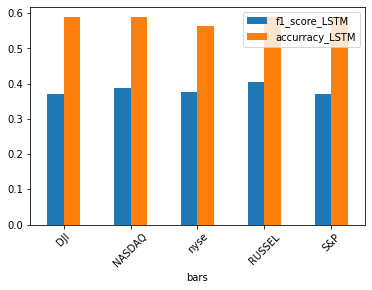

In [ ]:
accurracy_LSTM=[accuracy_score(result_dji_full,y_test[win_length:]),accuracy_score(result_nasdaq_full,  y_test[win_length:]),accuracy_score(result_nyse_full,  y_test[win_length:]),accuracy_score(result_russell_full,  y_test[win_length:]),accuracy_score(result_sp_full,  y_test[win_length:])]
f1_score_LSTM=[f1_score(result_dji_full, y_test[win_length:], average='macro'),f1_score(result_nasdaq_full, y_test[win_length:], average='macro'),f1_score(result_nyse_full, y_test[win_length:], average='macro'),f1_score(result_russell_full, y_test[win_length:], average='macro'),f1_score(result_sp_full, y_test[win_length:], average='macro')]

new_zip=(f1_score_LSTM,accurracy_LSTM)
bars=['DJI','NASDAQ','nyse','RUSSEL','S&P']

raw=pd.DataFrame({
    'bars':bars,
    'f1_score_LSTM':f1_score_LSTM,
     'accurracy_LSTM':accurracy_LSTM,
     })
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
raw.plot(x="bars", y=["f1_score_LSTM", "accurracy_LSTM"], kind="bar")
plt.xticks(rotation=45)

##**2d_CNN**

In [ ]:
#LOAD DATA 
# Sequential flatten (full features)
dji_X_seq_flatten = sequential_reshape(dji_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
nasdaq_X_seq_flatten = sequential_reshape(nasdaq_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
nyse_X_seq_flatten = sequential_reshape(nyse_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
russell_X_seq_flatten = sequential_reshape(russell_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
sp_X_seq_flatten = sequential_reshape(sp_X_seq, (len(dji_X_seq), sequence_length, -1, 1))

#80/10/10
## Full features
dji_X_train_full, dji_X_test_full, dji_y_train_full, dji_y_test_full = train_test_split(dji_X_seq_flatten,
                                                                                        dji_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
dji_X_train_full, dji_X_valid_full, dji_y_train_full, dji_y_valid_full = train_test_split(dji_X_train_full,
                                                                                        dji_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nasdaq_X_train_full, nasdaq_X_test_full, nasdaq_y_train_full, nasdaq_y_test_full = train_test_split(nasdaq_X_seq_flatten,
                                                                                        nasdaq_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nasdaq_X_train_full, nasdaq_X_valid_full, nasdaq_y_train_full, nasdaq_y_valid_full = train_test_split(nasdaq_X_train_full,
                                                                                        nasdaq_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nyse_X_train_full, nyse_X_test_full, nyse_y_train_full, nyse_y_test_full = train_test_split(nyse_X_seq_flatten,
                                                                                        nyse_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
nyse_X_train_full, nyse_X_valid_full, nyse_y_train_full, nyse_y_valid_full = train_test_split(nyse_X_train_full,
                                                                                        nyse_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)

russell_X_train_full, russell_X_test_full, russell_y_train_full, russell_y_test_full = train_test_split(russell_X_seq_flatten,
                                                                                        russell_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
russell_X_train_full, russell_X_valid_full, russell_y_train_full, russell_y_valid_full = train_test_split(russell_X_train_full,
                                                                                        russell_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
sp_X_train_full, sp_X_test_full, sp_y_train_full, sp_y_test_full = train_test_split(sp_X_seq_flatten,
                                                                                        sp_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
sp_X_train_full, sp_X_valid_full, sp_y_train_full, sp_y_valid_full = train_test_split(sp_X_train_full,
                                                                                        sp_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)

In [ ]:
print(dji_X_train_full.shape)
print(dji_X_valid_full.shape)
print(dji_X_test_full.shape)

(1395, 60, 82, 1)
(156, 60, 82, 1)
(173, 60, 82, 1)


In [ ]:
#combine all the data sets
# full
# Train
X_train_full = np.concatenate(
    (dji_X_train_full,
     nasdaq_X_train_full,
     nyse_X_train_full,
     russell_X_train_full,
     sp_X_train_full)
)
y_train_full = np.concatenate(
    (np.array(dji_y_train_full),
     np.array(nasdaq_y_train_full),
     np.array(nyse_y_train_full),
     np.array(russell_y_train_full),
     np.array(sp_y_train_full)
    )
)

# Valid
X_valid_full = np.concatenate(
    (dji_X_valid_full,
     nasdaq_X_valid_full,
     nyse_X_valid_full,
     russell_X_valid_full,
     sp_X_valid_full)
)
y_valid_full = np.concatenate(
    (np.array(dji_y_valid_full),
     np.array(nasdaq_y_valid_full),
     np.array(nyse_y_valid_full),
     np.array(russell_y_valid_full),
     np.array(sp_y_valid_full)
    )
)

In [ ]:
model_full = cnnpred_2d(60, 82, [8, 8, 8])
epochs = 100
batch_size=128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_full.compile(optimizer="Adam", loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_full.fit(X_train_full, y_train_full, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_full, y_valid_full))

Epoch 1/100
55/55 [==============================] - 2s 17ms/step - loss: 0.6902 - acc: 0.5355 - f1: 0.4933 - val_loss: 0.6947 - val_acc: 0.5167 - val_f1: 0.3966
Epoch 2/100
55/55 [==============================] - 1s 12ms/step - loss: 0.6780 - acc: 0.5699 - f1: 0.5214 - val_loss: 0.7001 - val_acc: 0.4987 - val_f1: 0.4011
Epoch 3/100
55/55 [==============================] - 1s 13ms/step - loss: 0.6699 - acc: 0.5913 - f1: 0.5408 - val_loss: 0.7050 - val_acc: 0.4756 - val_f1: 0.4061
Epoch 4/100
55/55 [==============================] - 1s 12ms/step - loss: 0.6591 - acc: 0.6130 - f1: 0.5897 - val_loss: 0.7128 - val_acc: 0.4577 - val_f1: 0.3989
Epoch 5/100
55/55 [==============================] - 1s 12ms/step - loss: 0.6490 - acc: 0.6301 - f1: 0.6126 - val_loss: 0.7217 - val_acc: 0.4705 - val_f1: 0.3974
Epoch 6/100
55/55 [==============================] - 1s 13ms/step - loss: 0.6326 - acc: 0.6452 - f1: 0.6309 - val_loss: 0.7340 - val_acc: 0.4885 - val_f1: 0.4142
Epoch 7/100
55/55 [=========

In [ ]:
## DJI
result_dji_full = model_full.predict(dji_X_test_full)
result_dji_full = (result_dji_full > 0.5).astype(int)
print(f"DJI Accuracy: {accuracy_score(result_dji_full, dji_y_test_full)}")
print(f"DJI F1: {f1_score(result_dji_full, dji_y_test_full, average='macro')}")

DJI Accuracy: 0.5202312138728323
DJI F1: 0.5009557571334237


In [ ]:
## NASDAQ
result_nasdaq_full = model_full.predict(nasdaq_X_test_full)
result_nasdaq_full = (result_nasdaq_full > 0.5).astype(int)
print(f"NASDAQ Accuracy: {accuracy_score(result_nasdaq_full, nasdaq_y_test_full)}")
print(f"NASDAQ F1: {f1_score(result_nasdaq_full, nasdaq_y_test_full, average='macro')}")

NASDAQ Accuracy: 0.5202312138728323
NASDAQ F1: 0.4985156986693675


In [ ]:
## nyse
result_nyse_full = model_full.predict(nyse_X_test_full)
result_nyse_full = (result_nyse_full > 0.5).astype(int)
print(f"nyse Accuracy: {accuracy_score(result_nyse_full, nyse_y_test_full)}")
print(f"nyse F1: {f1_score(result_nyse_full, nyse_y_test_full, average='macro')}")

nyse Accuracy: 0.47398843930635837
nyse F1: 0.45535374502681203


In [ ]:
## russell
result_russell_full = model_full.predict(russell_X_test_full)
result_russell_full = (result_russell_full > 0.5).astype(int)
print(f"russell Accuracy: {accuracy_score(result_russell_full, russell_y_test_full)}")
print(f"russell F1: {f1_score(result_russell_full, russell_y_test_full, average='macro')}")

russell Accuracy: 0.45664739884393063
russell F1: 0.43345875139353396


In [ ]:
## sp
result_sp_full = model_full.predict(sp_X_test_full)
result_sp_full = (result_sp_full > 0.5).astype(int)
print(f"S&P 500 Accuracy: {accuracy_score(result_sp_full, sp_y_test_full)}")
print(f"S&P 500 F1: {f1_score(result_sp_full, sp_y_test_full, average='macro')}")

S&P 500 Accuracy: 0.5202312138728323
S&P 500 F1: 0.5032347344750043


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

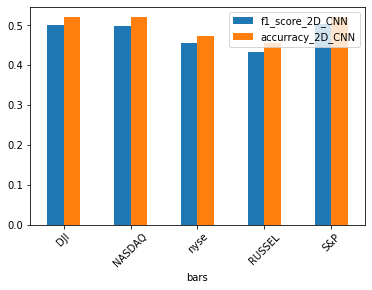

In [ ]:
accurracy_2D_CNN=[accuracy_score(result_dji_full, dji_y_test_full),accuracy_score(result_nasdaq_full, nasdaq_y_test_full),accuracy_score(result_nyse_full, nyse_y_test_full),accuracy_score(result_russell_full, russell_y_test_full),accuracy_score(result_sp_full, sp_y_test_full)]
f1_score_2D_CNN=[f1_score(result_dji_full, dji_y_test_full, average='macro'),f1_score(result_nasdaq_full, nasdaq_y_test_full, average='macro'),f1_score(result_nyse_full, nyse_y_test_full, average='macro'),f1_score(result_russell_full, russell_y_test_full, average='macro'),f1_score(result_sp_full, sp_y_test_full, average='macro')]

new_zip=(f1_score_2D_CNN,accurracy_2D_CNN)
bars=['DJI','NASDAQ','nyse','RUSSEL','S&P']

raw=pd.DataFrame({
    'bars':bars,
    'f1_score_2D_CNN':f1_score_2D_CNN,
     'accurracy_2D_CNN':accurracy_2D_CNN,
     })
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
raw.plot(x="bars", y=["f1_score_2D_CNN", "accurracy_2D_CNN"], kind="bar")
plt.xticks(rotation=45)

#TCN 

https://www.kaggle.com/christofhenkel/temporal-convolutional-network

In [ ]:
!pip install wget
!pip install keras-tcn
import wget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tcn import TCN

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=dc3ac2b8c3426544cd5617bffa78269de2754bc6cb330850ac935727ecf2dfd6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 1.1 MB 7.5 MB/s 


In [ ]:
#LOAD DATA 
# Sequential flatten (full features)
dji_X_seq_flatten = sequential_reshape(dji_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
nasdaq_X_seq_flatten = sequential_reshape(nasdaq_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
nyse_X_seq_flatten = sequential_reshape(nyse_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
russell_X_seq_flatten = sequential_reshape(russell_X_seq, (len(dji_X_seq), sequence_length, -1, 1))
sp_X_seq_flatten = sequential_reshape(sp_X_seq, (len(dji_X_seq), sequence_length, -1, 1))

#80/10/10
## Full features
dji_X_train_full, dji_X_test_full, dji_y_train_full, dji_y_test_full = train_test_split(dji_X_seq_flatten,
                                                                                        dji_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
dji_X_train_full, dji_X_valid_full, dji_y_train_full, dji_y_valid_full = train_test_split(dji_X_train_full,
                                                                                        dji_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nasdaq_X_train_full, nasdaq_X_test_full, nasdaq_y_train_full, nasdaq_y_test_full = train_test_split(nasdaq_X_seq_flatten,
                                                                                        nasdaq_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nasdaq_X_train_full, nasdaq_X_valid_full, nasdaq_y_train_full, nasdaq_y_valid_full = train_test_split(nasdaq_X_train_full,
                                                                                        nasdaq_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
nyse_X_train_full, nyse_X_test_full, nyse_y_train_full, nyse_y_test_full = train_test_split(nyse_X_seq_flatten,
                                                                                        nyse_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
nyse_X_train_full, nyse_X_valid_full, nyse_y_train_full, nyse_y_valid_full = train_test_split(nyse_X_train_full,
                                                                                        nyse_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)

russell_X_train_full, russell_X_test_full, russell_y_train_full, russell_y_test_full = train_test_split(russell_X_seq_flatten,
                                                                                        russell_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
russell_X_train_full, russell_X_valid_full, russell_y_train_full, russell_y_valid_full = train_test_split(russell_X_train_full,
                                                                                        russell_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
sp_X_train_full, sp_X_test_full, sp_y_train_full, sp_y_test_full = train_test_split(sp_X_seq_flatten,
                                                                                        sp_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
sp_X_train_full, sp_X_valid_full, sp_y_train_full, sp_y_valid_full = train_test_split(sp_X_train_full,
                                                                                        sp_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
print(dji_X_train_full.shape)
print(dji_X_valid_full.shape)
print(dji_X_test_full.shape)

#combine all the data sets
# full
# Train
X_train_full = np.concatenate(
    (dji_X_train_full,
     nasdaq_X_train_full,
     nyse_X_train_full,
     russell_X_train_full,
     sp_X_train_full)
)
y_train_full = np.concatenate(
    (np.array(dji_y_train_full),
     np.array(nasdaq_y_train_full),
     np.array(nyse_y_train_full),
     np.array(russell_y_train_full),
     np.array(sp_y_train_full)
    )
)

# Valid
X_valid_full = np.concatenate(
    (dji_X_valid_full,
     nasdaq_X_valid_full,
     nyse_X_valid_full,
     russell_X_valid_full,
     sp_X_valid_full)
)
y_valid_full = np.concatenate(
    (np.array(dji_y_valid_full),
     np.array(nasdaq_y_valid_full),
     np.array(nyse_y_valid_full),
     np.array(russell_y_valid_full),
     np.array(sp_y_valid_full)
    )
)

(1395, 60, 82, 1)
(156, 60, 82, 1)
(173, 60, 82, 1)


In [ ]:
lookback_window = 12 

In [ ]:
dji_X_train_full.shape[-2]

82

epochs = 200
batch_size=128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_full.compile(optimizer="Adam", loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_full.fit(X_train_full, y_train_full, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_full, y_valid_full))

In [ ]:
X_train_full.shape[-2]

82

In [ ]:
#i= Input(shape=(80, 62, 1))
i = Input(shape=(60, 82))
m = TCN()(i)
m = Dense(1, activation = 'sigmoid')(m)
#early_stopping = EarlyStopping(patience = 50, restore_best_weights=True, min_delta = 0.000)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)
model_TCN = Model(inputs=[i], outputs=[m])
model_TCN.summary()
#model_full.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["acc", f1])
model_TCN.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = 1e-3),metrics=["acc", f1])
#model_TCN.reset_states()
#model_TCN.fit(X_train_full, y_train_full,validation_data = (X_valid_full, y_valid_full),shuffle = False, callbacks = [early_stopping, reduceLR],batch_size = 8, epochs = 200)

model_TCN.fit(X_train_full, y_train_full, epochs=100, batch_size=8, callbacks=[early_stopping,reduceLR],shuffle = False,validation_data=(X_valid_full, y_valid_full))


#model_TCN.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["acc", f1])
#model_TCN.fit(X_train_full, y_train_full, epochs=epochs,batch_size=batch_size, callbacks=[early_stopping],validation_data=(X_valid_full, y_valid_full))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 82)]          0         
                                                                 
 tcn (TCN)                   (None, 64)                156992    
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 157,057
Trainable params: 157,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
872/872 [==============================] - 25s 27ms/step - loss: 0.7154 - acc: 0.6427 - f1: 0.5919 - val_loss: 0.9914 - val_acc: 0.5128 - val_f1: 0.4187 - lr: 0.0010
Epoch 2/100
872/872 [==============================] - 23s 26ms/step - loss: 0.4185 - acc: 0.8219 - f1: 0.7971 - val_loss: 1.0071 - val_acc: 

In [ ]:
## DJI
result_dji_full = model_TCN.predict(dji_X_test_full)
result_dji_full = (result_dji_full > 0.5).astype(int)
print(f"DJI Accuracy: {accuracy_score(result_dji_full, dji_y_test_full)}")
print(f"DJI F1: {f1_score(result_dji_full, dji_y_test_full, average='macro')}")

DJI Accuracy: 0.5375722543352601
DJI F1: 0.5007215007215007


In [ ]:
## NASDAQ
result_nasdaq_full = model_TCN.predict(nasdaq_X_test_full)
result_nasdaq_full = (result_nasdaq_full > 0.5).astype(int)
print(f"NASDAQ Accuracy: {accuracy_score(result_nasdaq_full, nasdaq_y_test_full)}")
print(f"NASDAQ F1: {f1_score(result_nasdaq_full, nasdaq_y_test_full, average='macro')}")

NASDAQ Accuracy: 0.5549132947976878
NASDAQ F1: 0.5028179001978128


In [ ]:
## nyse
result_nyse_full = model_TCN.predict(nyse_X_test_full)
result_nyse_full = (result_nyse_full > 0.5).astype(int)
print(f"nyse Accuracy: {accuracy_score(result_nyse_full, nyse_y_test_full)}")
print(f"nyse F1: {f1_score(result_nyse_full, nyse_y_test_full, average='macro')}")

nyse Accuracy: 0.4682080924855491
nyse F1: 0.4218250508573089


In [ ]:
## russell
result_russell_full = model_TCN.predict(russell_X_test_full)
result_russell_full = (result_russell_full > 0.5).astype(int)
print(f"russell Accuracy: {accuracy_score(result_russell_full, russell_y_test_full)}")
print(f"russell F1: {f1_score(result_russell_full, russell_y_test_full, average='macro')}")

russell Accuracy: 0.5144508670520231
russell F1: 0.4792144495412844


In [ ]:
## sp
result_sp_full = model_TCN.predict(sp_X_test_full)
result_sp_full = (result_sp_full > 0.5).astype(int)
print(f"S&P 500 Accuracy: {accuracy_score(result_sp_full, sp_y_test_full)}")
print(f"S&P 500 F1: {f1_score(result_sp_full, sp_y_test_full, average='macro')}")

S&P 500 Accuracy: 0.5144508670520231
S&P 500 F1: 0.46823770491803274


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

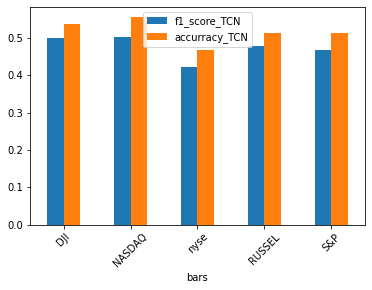

In [ ]:
accurracy_TCN=[accuracy_score(result_dji_full, dji_y_test_full),accuracy_score(result_nasdaq_full, nasdaq_y_test_full),accuracy_score(result_nyse_full, nyse_y_test_full),accuracy_score(result_russell_full, russell_y_test_full),accuracy_score(result_sp_full, sp_y_test_full)]
f1_score_TCN=[f1_score(result_dji_full, dji_y_test_full, average='macro'),f1_score(result_nasdaq_full, nasdaq_y_test_full, average='macro'),f1_score(result_nyse_full, nyse_y_test_full, average='macro'),f1_score(result_russell_full, russell_y_test_full, average='macro'),f1_score(result_sp_full, sp_y_test_full, average='macro')]

new_zip=(f1_score_TCN,accurracy_TCN)
bars=['DJI','NASDAQ','nyse','RUSSEL','S&P']

raw=pd.DataFrame({
    'bars':bars,
    'f1_score_TCN':f1_score_TCN,
     'accurracy_TCN':accurracy_TCN,
     })
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
raw.plot(x="bars", y=["f1_score_TCN", "accurracy_TCN"], kind="bar")
plt.xticks(rotation=45)